#**Распознавание урбанизированных территорий**

# Цель, задачи и критерии выбора нейронной сети

**Цель:**
Создание геоизображений урбанизированных территорий

**Задачи:** 
1. Сегментация космических снимков малого пространственного разрешения (на примере урбанизированных территорий на границе Индии и Непала, в районе Патны).
2. Создание программы для формирования результата сегментации в векторном формате с сохранением географической привязки

**В зависимости от получаемого результата выбраны следующие критерии выбора архитектуры сети:**
*   Согласованность выделенных полигонов с местностью
*   Высокая точность работы нейронной сети (более 90 %)
*   Малое количество артефактов (отсутствие зернистости, случайных мелких деталей)

# Загрузка данных

**Концепция преобразования данных для для обучения с учителем:**
*   Создать обучающую, проверочную и тестовую выборки, состоящие из исходных и сегментированных изображений
*   Преобразовать сегментированные изображения в массивы двоичных данных (каждый пиксель изображения отнести или к фону, или к целевой территории)
*   Создать и обучить сверточные нейронные сети с архитектурами различного уровня сложности

https://drive.google.com/drive/folders/1cBf1WXID1rSE_wDUZXTRXrJodd-abmOr?usp=sharing

In [ ]:
from google.colab import drive #Работа с google-диском
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Работа с библиотекой keras нейросетевой обработки данных
from tensorflow.keras.models import Model, model_from_json #Методы создания и загрузки модели
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Reshape, Flatten, Dense #Стандартные слои
from tensorflow.keras import backend as K #Модуль внутрисистемной разработки
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras import utils #Утилиты (для двоичного кодирования данных, One Hot Encoding - OHE)
from tensorflow.keras.preprocessing import image #Модуль для работы с изображениями
from tensorflow.keras.utils import plot_model #Модуль для вывода модели

from google.colab import files #Работа с файлами google-диска

import numpy as np #Работа со специальными массивами
from sklearn.model_selection import train_test_split #Работа с разделением набора данных
import scipy.ndimage #Работа со специальной обработкой массивов

import time #Работа со временем
import random #Работа со случайными числами
import os #Работа с файловой системой

from PIL import Image #Работа с изображениями
import matplotlib.pyplot as plt #Работа с наглядным выводом данных

In [ ]:
#Основные параметры
#База состоит из 2000 геопривязанных изображений
#База разбита заранее на 3 выборки: 1800/100/100
#Каждой выборка состоит из набора исходных, сегментированных изображений и файлов геопривязки
#Совмещение в одной папке файлов геопривязки и рабочего изображения даёт возможность работать с данными в геоинформационной системе

img_width = 384 #Ширина изображения 
img_height = 368 #Высота изображения
num_classes = 2 #Количество классов на изображении
directory = '/content/drive/My Drive/Segmentation_Urban_Area/Urban_Area/'

train_directory = '1_Training_set' #Обучающая выборка
val_directory = '2_Validation_set' #Проверочная выборка
test_directory = '3_Test_set' #Тестовая выборка

In [ ]:
#Загрузка данных. Формирование массивов данных

train_images = [] #Массив исходных изображений обучающей выборки
val_images = [] #Массив исходных изображений проверочной выборки
train_segments = [] #Массив сегментированных изображений обучающей выборки
val_segments = [] #Массив сегментированных изображений проверочной выборки

cur_time = time.time() #Начало отсчёта времени
for filename in sorted(os.listdir(directory + train_directory+'/Initial')): #Проход по файлам из директории с исходными изображениями обучающей выборки   
  train_images.append(image.load_img(os.path.join(directory + train_directory+'/Initial',filename), target_size=(img_height, img_width))) #Чтение и запись изображений в массив с указанными размерами                                                   
print ('Исходные изображения обучающей выборки загружены. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') #Отображение времени загрузки
print ('Количество изображений: ', len(train_images)) #Отображение количества записей

cur_time = time.time()
for filename in sorted(os.listdir(directory + val_directory+'/Initial')): #Проход по файлам из директории с исходными изображениями проверочной выборки
  val_images.append(image.load_img(os.path.join(directory + val_directory+'/Initial',filename), target_size=(img_height, img_width))) #Чтение и запись изображений в массив с указанными размерами
print ('Исходные изображения проверочной выборки загружены. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') #Отображение времени загрузки
print ('Количество изображений: ', len(val_images)) #Отображение количества записей

cur_time = time.time()
for filename in sorted(os.listdir(directory + train_directory+'/Segmented')): #Проход по файлам из директории с сегментированными изображениями обучающей выборки 
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Segmented',filename), target_size=(img_height, img_width))) #Чтение и запись изображений в массив с указанными размерами                                                    
print ('Сегментированные изображения обучающей выборки загружены. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') #Отображение времени загрузки
print ('Количество изображений: ', len(train_segments)) #Отображение количества записей

cur_time = time.time()
for filename in sorted(os.listdir(directory + val_directory+'/Segmented')): #Проход по файлам из директории с сегментированными изображениями проверочной выборки                                    
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Segmented',filename), target_size=(img_height, img_width))) #Чтение и запись изображений в массив с указанными размерами
print ('Сегментированные изображения проверочной выборки загружены. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') #Отображение времени загрузки
print ('Количество изображений: ', len(val_segments)) #Отображение количества записей

Исходные изображения обучающей выборки загружены. Время загрузки: 9.01c
Количество изображений:  1800
Исходные изображения проверочной выборки загружены. Время загрузки: 0.49c
Количество изображений:  100
Сегментированные изображения обучающей выборки загружены. Время загрузки: 5.44c
Количество изображений:  1800
Сегментированные изображения проверочной выборки загружены. Время загрузки: 0.31c
Количество изображений:  100


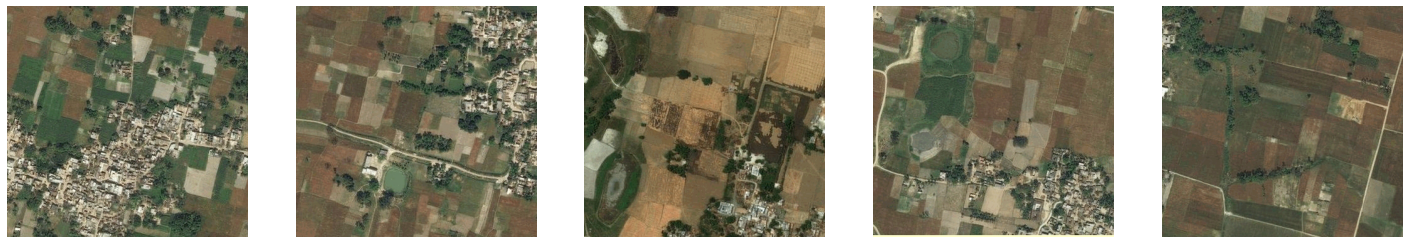

In [ ]:
#Случайные n исходных изображений обучающей выборки
n = 5 #Количество выводимых изображений
fig, axs = plt.subplots(1, n, figsize=(25, 10)) #Создание полотна из n исходных изображений
for i in range(n): #Проход по n
  img = random.choice(train_images) #Выбор случайного исходного изображения
  axs[i].axis('off') #Отключение осей
  axs[i].imshow(img) #Отображение изображения
plt.show() #Отображение полотна

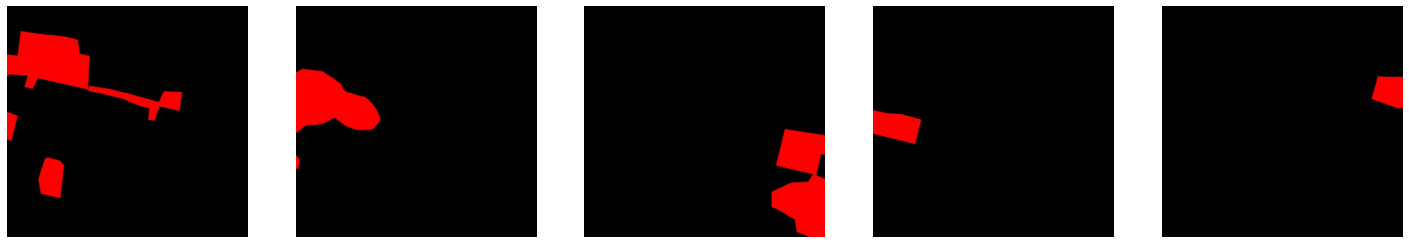

In [ ]:
#Случайные n сегментированных изображений обучающей выборки
n = 5 #Количество выводимых изображений
fig, axs = plt.subplots(1, n, figsize=(25, 10)) #Создание полотна из n сегментированных изображений
for i in range(n): #Проход по n
  img = random.choice(train_segments) #Выбор случайного сегментированного изображения
  axs[i].axis('off') #Отключение осей
  axs[i].imshow(img) #Отображение изображения
plt.show() #Отображение полотна

In [ ]:
#Функция преобразования пикселя сегментированного изображения в индекс
#Если цвет близкий к черному - то индекс 0, иначе - индекс 1
def color2index(color):
  index=0 #Установка 0 по-умолчанию (фон)
  if (color[0] + color[1] + color[2]) > 20: #Установка 1 для всех цветов, кроме черного и близких к чёрному (урбанизированные территории)
    index = 1
  return index #Вывод индекса

#Функция преобразования индекса в цвет пикселя
#Если индекс 0 - то черный цвет, если индекс 1 - то красный
def index2color(index2):
  index = np.argmax(index2) #Получение индекса максимального элемента
  color = [] #Создание массива для записи чистого цвета
  if index == 0:
    color = [0, 0, 0] #Черный для записи фона
  elif index == 1:
    color = [255, 0, 0] #Красный для записи урбанизированных территорий
  return color #Вывод одномерного массива

#Функция перевода индекса пикселя в OHE (каждый пиксель будет записан двоичным кодом)
#Трехмерный массив > Вектор из 0 или 1 > Трехмерный массив из [0,1] или [1,0]
def rgbToohe(y, num_classes): 
  y2 = y.copy() #Копирование входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) #Перевод трехмерного массива в двумерный
  yt = [] #Создание массива для записи двоичных OHE-данных
  for i in range(len(y)): #Проход по трём каналам изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) #Перевод пикселей в индексы, преобразование в OHE, запись в массив
  yt = np.array(yt) #Конвертация в numpy-массив
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) #Перевод двумерного массива в трехмерный
  return yt #Вывод трехмерного массива [высота, ширина, 2 канала]

#Функция формирования yTrain
#Работа функции rgbToohe() для сегментированных изображений выборок
def yt_prep(data, num_classes):
  yTrain = [] #Создание массива под карты сегментации
  for seg in data: #Проход по файлам набора с сегментированными изображениями
    y = image.img_to_array(seg) #Перевод изображения в массив [высота,  ширина, каналы]
    y = rgbToohe(y, num_classes) #Получение OHE-представления сформированного массива
    yTrain.append(y) #Запись OHE-представления
    if len(yTrain) % 200 == 0: #Вывод при обработке каждых 200 изображений
      print(len(yTrain)) #Вывод количества обработанных изображений
  return np.array(yTrain) #Вывод четырехмерного массива [количество, высота, ширина, 2 канала] 

#Функция визуализации сегментированных изображений
#Предсказание, сегментированный тест > Сырой вектор вероятностей > Классификация через функцию index2color() > Трехмерный массив 
def processImage(model, count, n_classes):
  indexes = np.random.randint(0, len(xVal), count) #Получение count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создание полотна из n изображений
  for i,idx in enumerate(indexes): #Проход по сгенерированным случайным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_height, img_width, 3))) #Предсказание
    pr = predict[0] #Нулевой элемент из предсказания [1, высота, ширина, каналы]
    pr1 = [] #Создание массива под сегментированное изображение из предсказания
    pr2 = [] #Создание массива под сегментированное изображение из тестовой выборки
    pr = pr.reshape(-1, n_classes) #Изменение размерности предсказания [высота * ширина, каналы]
    yr = yVal[idx].reshape(-1, n_classes) #Изменение размерности тестовых данных [высота * ширина, каналы]
    for k in range(len(pr)): # Проход по количеству классов
      pr1.append(index2color(pr[k])) #Запись перевода индекса в пиксель
      pr2.append(index2color(yr[k])) #Запись перевода индекса в пиксель
    pr1 = np.array(pr1) #Преобразование в numpy-массив
    pr1 = pr1.reshape(img_height, img_width,3) #Довод к размерности изображения
    pr2 = np.array(pr2)  #Преобразование в numpy-массив
    pr2 = pr2.reshape(img_height, img_width,3) #Довод к размерности изображения
    img = Image.fromarray(pr1.astype('uint8')) #Получение изображения из предсказания
    axs[0,i].imshow(img.convert('RGBA')) #Отображение на первой линии (предсказания)
    axs[0,i].axis('off') #Отключение осей
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) #Отображение на второй линии (сегментированные изображения из тестовой выборки)
    axs[1,i].axis('off') #Отключение осей
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) #Отображение на третьей линии (оригиналы)     
    axs[2,i].axis('off') #Отключение осей
  plt.show() #Отображение полотна  

#Функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) #Определение площади пересечения, деленную на площадь объединения двух областей

In [ ]:
#Формирование xTrain для обучающий выборки
xTrain = [] #Массив для обучающей выборки
for img in train_images: #Проход по всем изображениям из набора
  x = image.img_to_array(img) #Преобразование в массив [высота,  ширина, каналы]
  xTrain.append(x) #Запись в массив
xTrain = np.array(xTrain) #Преобразование в numpy-массив [количество, высота,  ширина, каналы]

#Формирование xVal для проверочной выборки
xVal = [] #Массив для проверочной выборки
for img in val_images: #Проход по всем изображениям из набора
  x = image.img_to_array(img) #Преобразование в массив [высота,  ширина, каналы]
  xVal.append(x) #Запись в массив
xVal = np.array(xVal) #Преобразование в numpy-массив [количество, высота,  ширина, каналы]

print(xTrain.shape)
print(xVal.shape)

(1800, 368, 384, 3)
(100, 368, 384, 3)


In [ ]:
#Формирование yTrain для обучающей выборки
cur_time = time.time() #Начало отсчёта времени 
yTrain = yt_prep(train_segments, num_classes) #Работа функции rgbToohe() для сегментированных изображений обучающей выборки
print('Время обработки: ', round(time.time() - cur_time, 2),'c') #Вывод времени работы

200
400
600
800
1000
1200
1400
1600
1800
Время обработки:  2551.35 c


In [ ]:
#Формирование yVal для проверочной выборки
cur_time = time.time() #Начало отсчёта времени
yVal = yt_prep(val_segments, num_classes) #Работа функции rgbToohe() для сегментированных изображений проверочной выборки
print('Время обработки: ', round(time.time() - cur_time, 2),'c') #Вывод времени работы

Время обработки:  138.11 c


# Linear net 1

In [ ]:
#Линейная сеть Conv2D
def linearnet1(num_classes, input_shape):
    img_input = Input(input_shape) #Входной слой с размерностью input_shape                                          
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) #Двумерный сверточный слой, 128 нейронов (padding same - окно свертки будет всегда одинаковым, добавляя поля)
    x = BatchNormalization()(x) #Слой нормализации входных данных (для ускорения обучения)                                         
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель (реализует простой пороговый переход в нуле, привносит нелинейность) https://www.machinelearningmastery.ru/img/0-419460-927905.gif                                           

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x) #Двумерный сверточный слой, 128 нейронов        
    x = BatchNormalization()(x) #Слой нормализации входных данных                                             
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель                                        

    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) #Двумерный сверточный слой, 2 нейрона
    #для представления категориального распределения по меткам классов и получения вероятностей каждого входного элемента, принадлежащего метке

    model = Model(img_input, x) #Создание модели со входом img_input и выходом x                                          
    model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=[dice_coef]) #Компиляция модели
    #функция ошибки, кроссэнтропию, используется для задач мультиклассовой классификации (можно по идее и бинарную использовать), 
    #предназначена для количественной оценки разницы между распределениями вероятностей
    
    return model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 368, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 368, 384, 128)     3584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 368, 384, 128)     512       
_________________________________________________________________
activation_2 (Activation)    (None, 368, 384, 128)     0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 368, 384, 128)     147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 368, 384, 128)     512       
_________________________________________________________________
activation_3 (Activation)    (None, 368, 384, 128)     0   

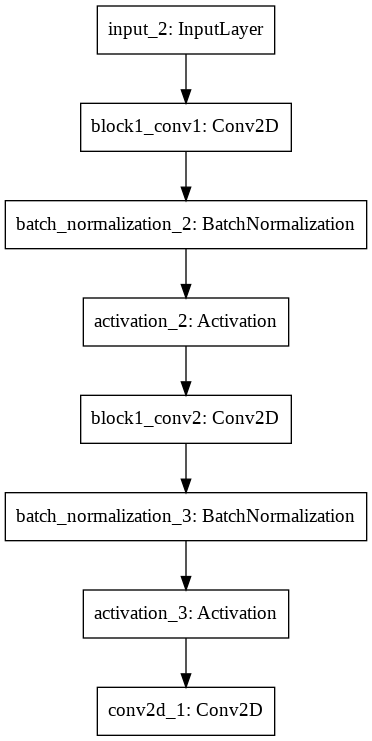

In [ ]:
#Формирование сети
modellinearnet1 = linearnet1(num_classes, (img_height, img_width, 3)) #Создание модели
modellinearnet1.summary() #Отображение содержания модели
plot_model(modellinearnet1, to_file='modellinearnet1.png') #Логическое отображение содержания модели

In [ ]:
#Обучение
historylinearnet1 = modellinearnet1.fit(xTrain, yTrain, epochs=30, batch_size=10, validation_data=(xVal, yVal)) #Обучение модели

Epoch 1/30
180/180 [==============================] - 171s 952ms/step - loss: 0.1973 - dice_coef: 0.8901 - val_loss: 0.3384 - val_dice_coef: 0.8952
Epoch 2/30
180/180 [==============================] - 171s 949ms/step - loss: 0.1688 - dice_coef: 0.9025 - val_loss: 0.1884 - val_dice_coef: 0.9109
Epoch 3/30
180/180 [==============================] - 170s 947ms/step - loss: 0.1646 - dice_coef: 0.9048 - val_loss: 0.2973 - val_dice_coef: 0.8998
Epoch 4/30
180/180 [==============================] - 172s 958ms/step - loss: 0.1635 - dice_coef: 0.9061 - val_loss: 0.1777 - val_dice_coef: 0.8875
Epoch 5/30
180/180 [==============================] - 173s 962ms/step - loss: 0.1607 - dice_coef: 0.9071 - val_loss: 0.2087 - val_dice_coef: 0.9081
Epoch 6/30
180/180 [==============================] - 171s 949ms/step - loss: 0.1619 - dice_coef: 0.9070 - val_loss: 0.2179 - val_dice_coef: 0.8491
Epoch 7/30
180/180 [==============================] - 170s 947ms/step - loss: 0.1599 - dice_coef: 0.9081 - val_l

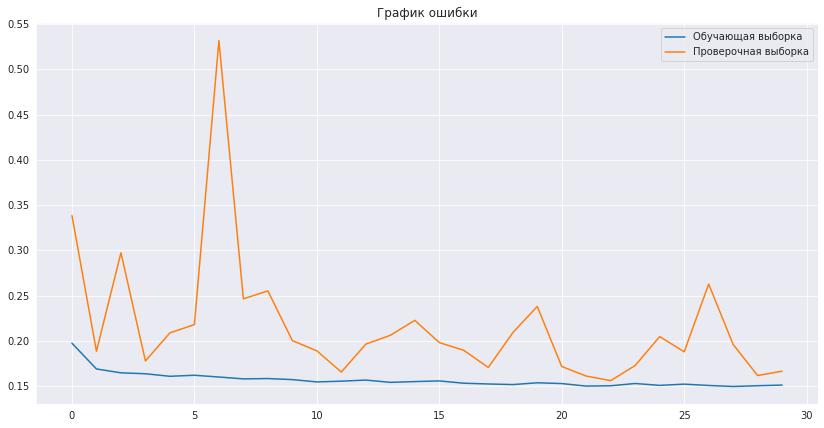

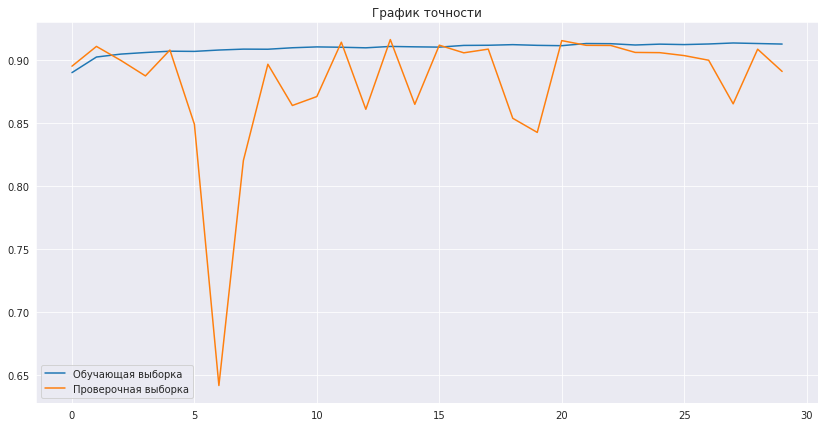

In [ ]:
#График ошибки
#loss - это значение функции потерь для обучающие выборки
#val_loss - это значение функции потерь с учетом проверочной выборки

plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historylinearnet1.history['loss'], label='Обучающая выборка')
plt.plot(historylinearnet1.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show() #Вывод полотна

#График точности
plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historylinearnet1.history['dice_coef'], label='Обучающая выборка')
plt.plot(historylinearnet1.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности') #Вывод полотна
plt.show()

In [ ]:
#Сохранение модели. Преобразование в JSON
modellinearnet1_json = modellinearnet1.to_json()
with open("/content/drive/My Drive/Segmentation_Urban_Area/Weights/modellinearnet1.json", "w") as json_file:
  json_file.write(modellinearnet1_json)

In [ ]:
#Сохранение весов
#modellinearnet1.save_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modellinearnet1.h5')
modellinearnet1.load_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modellinearnet1.h5')

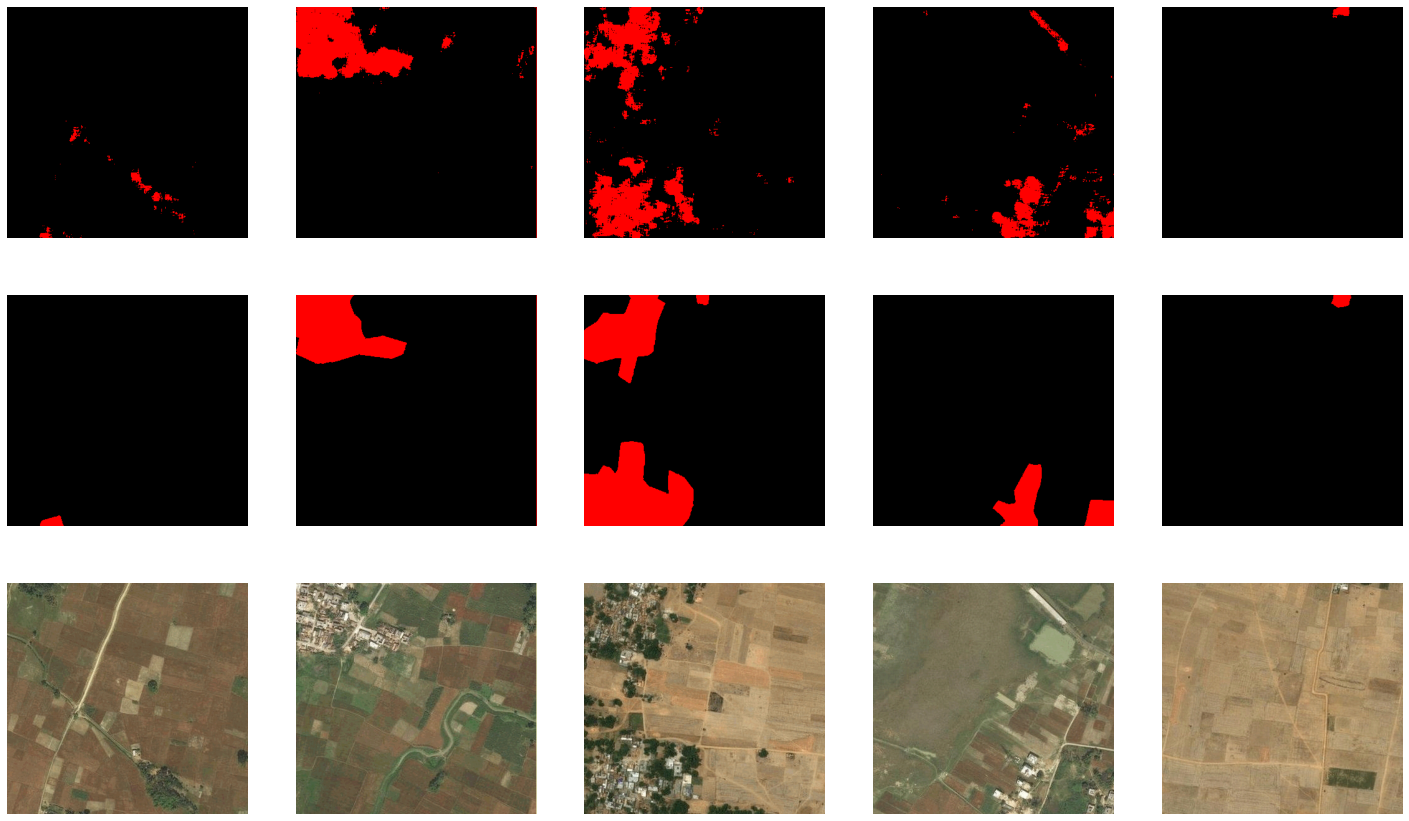

In [ ]:
#Проверка результата. Снизу-вверх: оригинал > сегментация исполнителя > предсказание нейросети
processImage(modellinearnet1, 5, num_classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


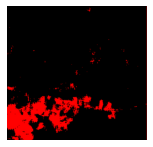

In [ ]:
#Проверка одной картинки. Добавлено масштабирование изображения для очистки от артефактов

modellinearnet1_json_file = open("/content/drive/My Drive/Segmentation_Urban_Area/Weights/modellinearnet1.json","r") 
loaded_modellinearnet1_json = modellinearnet1_json_file.read()
modellinearnet1_json_file.close()
loaded_modellinearnet1 = model_from_json(loaded_modellinearnet1_json)
loaded_modellinearnet1.summary()
loaded_modellinearnet1.load_weights("/content/drive/My Drive/Segmentation_Urban_Area/Weights/modellinearnet1.h5")
print("Загружено с диска")
loaded_modellinearnet1.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=[dice_coef])

def processImageOnly(model, filenamein, filenameout, n_classes):
  img_width_real = 387
  img_height_real = 372

  img = image.load_img(os.path.join(directory + test_directory+'/Initial',filenamein), target_size=(img_height, img_width))
  xTest = image.img_to_array(img)
  predict = np.array(model.predict(xTest.reshape(1, img_height, img_width, 3)))
  pr = predict[0]
  pr = pr.reshape(-1, n_classes)
  pr1 = []

  for k in range(len(pr)):
    pr1.append(index2color(pr[k]))

  pr1 = np.array(pr1)
  pr1 = pr1.reshape(img_height, img_width,3)  

  readyimg = Image.fromarray(pr1.astype('uint8'))
  dpi=200

  newpr = scipy.ndimage.zoom(pr1, (3, 3, 1))

  fig = plt.figure(frameon=False)
  fig.set_size_inches(img_width_real/dpi, img_height_real/dpi)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(newpr)
  plt.savefig(filenameout, dpi=dpi)

processImageOnly(loaded_modellinearnet1, "img_1975.jpg", "output.png", num_classes)


# Linear net 2 – усложнённая сеть

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 368, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 368, 384, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 368, 384, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 368, 384, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 368, 384, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 368, 384, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 368, 384, 128)     0     

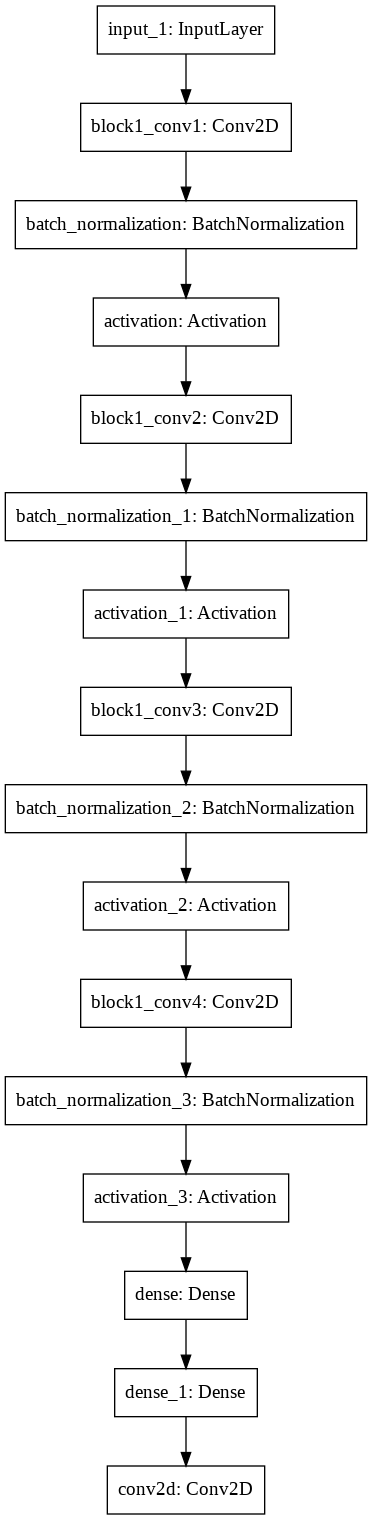

In [ ]:
#Линейная сеть Conv2D. Вариант 2
def linearnet2(num_classes, input_shape):
    img_input = Input(input_shape) #Входной слой с размерностью input_shape                                          
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных                                             
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель                                            

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных                                              
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель

    x = Conv2D(256, (3, 3), padding='same', name='block1_conv3')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных                                              
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель

    x = Conv2D(512, (3, 3), padding='same', name='block1_conv4')(x) #Двумерный сверточный слой, 512 нейронов        
    x = BatchNormalization()(x) #Слой нормализации входных данных                                              
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель

    x = Dense(200, activation="relu")(x) #Полносвязный слой, 200 нейронов
    x = Dense(100, activation="relu")(x) #Полносвязный слой, 100 нейронов

    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) #Двумерный сверточный слой, 2 нейрона, с активацией категориального распределения

    model = Model(img_input, x) #Создание модели со входом img_input и выходом x                                              
    model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=[dice_coef]) #Компиляция модели
    return model

#Формирование сети
modellinearnet2 = linearnet2(num_classes, (img_height, img_width, 3)) #Создание модели
modellinearnet2.summary() #Отображение содержания модели
plot_model(modellinearnet2, to_file='modellinearnet2.png') #Логическое отображение содержания модели    

In [ ]:
#Обучение
historylinearnet2 = modellinearnet2.fit(xTrain, yTrain, epochs=10, batch_size=5, validation_data=(xVal, yVal)) #Обучение модели

Epoch 1/10
360/360 [==============================] - 669s 2s/step - loss: 0.1694 - dice_coef: 0.9008 - val_loss: 0.1710 - val_dice_coef: 0.8950
Epoch 2/10
360/360 [==============================] - 663s 2s/step - loss: 0.1531 - dice_coef: 0.9113 - val_loss: 0.2338 - val_dice_coef: 0.9036
Epoch 3/10
360/360 [==============================] - 663s 2s/step - loss: 0.1485 - dice_coef: 0.9139 - val_loss: 0.2315 - val_dice_coef: 0.8388
Epoch 4/10
360/360 [==============================] - 663s 2s/step - loss: 0.1457 - dice_coef: 0.9158 - val_loss: 0.1708 - val_dice_coef: 0.9100
Epoch 5/10
360/360 [==============================] - 663s 2s/step - loss: 0.1430 - dice_coef: 0.9178 - val_loss: 0.1423 - val_dice_coef: 0.9146
Epoch 6/10
360/360 [==============================] - 663s 2s/step - loss: 0.1365 - dice_coef: 0.9212 - val_loss: 0.1802 - val_dice_coef: 0.9209
Epoch 7/10
360/360 [==============================] - 662s 2s/step - loss: 0.1374 - dice_coef: 0.9206 - val_loss: 0.1810 - val_dic

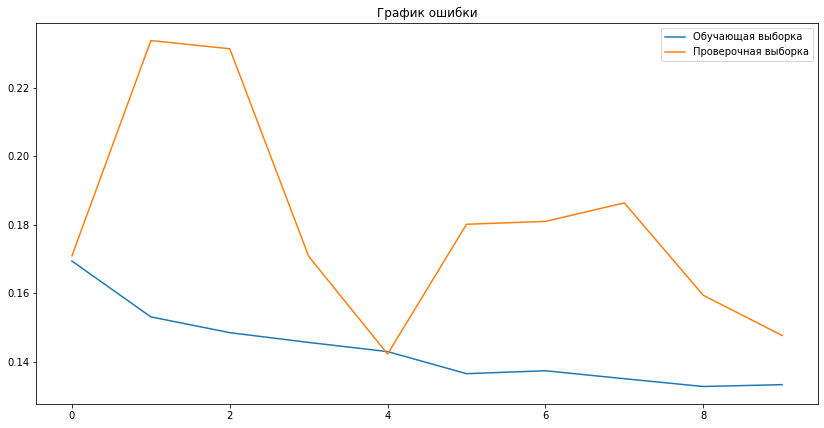

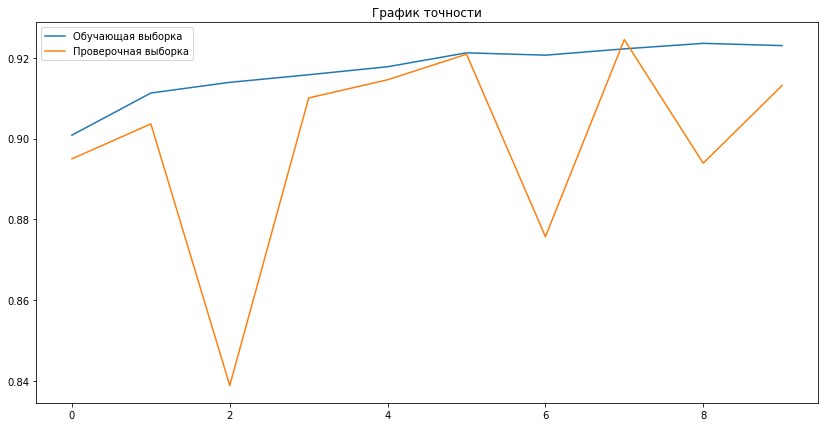

In [ ]:
#График ошибки
#loss - это значение функции потерь для обучающие выборки
#val_loss - это значение функции потерь с учетом проверочной выборки

plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historylinearnet2.history['loss'], label='Обучающая выборка')
plt.plot(historylinearnet2.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show() #Вывод полотна

#График точности
plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historylinearnet2.history['dice_coef'], label='Обучающая выборка')
plt.plot(historylinearnet2.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show() #Вывод полотна

In [ ]:
#Сохранение модели. Преобразование в JSON
modellinearnet2_json = modellinearnet2.to_json()
with open("/content/drive/My Drive/Segmentation_Urban_Area/Weights/modellinearnet2.json", "w") as json_file:
  json_file.write(modellinearnet2_json)

#Сохранение весов
modellinearnet2.save_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modellinearnet2.h5')
#modellinearnet2.load_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modellinearnet2.h5')  

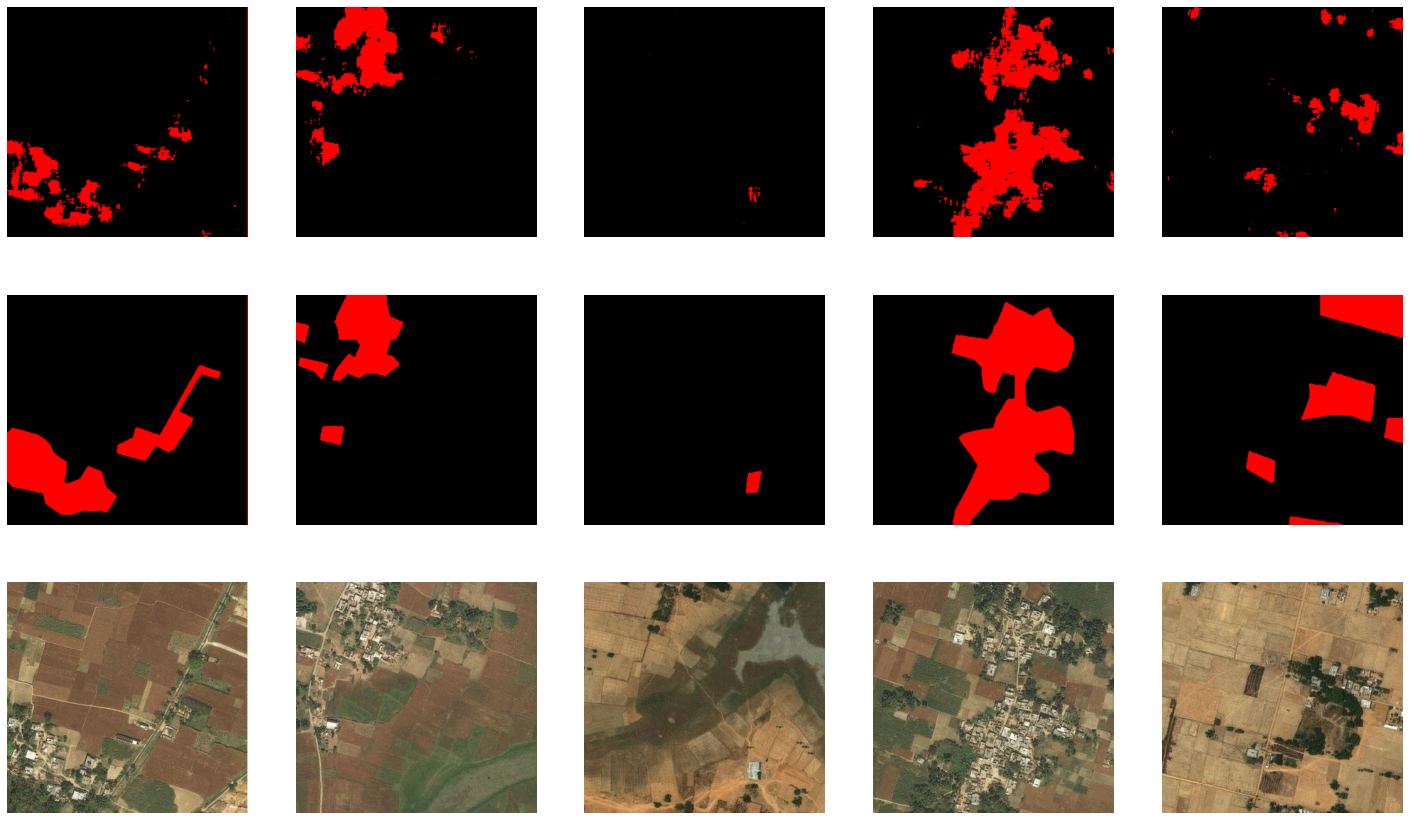

In [ ]:
#Проверка результата. Снизу-вверх: оригинал > сегментация исполнителя > предсказание нейросети
processImage(modellinearnet2, 5, num_classes)

# Unet 1

In [ ]:
#Сеть unet. Вариант 1
def unet1(num_classes, input_shape):
    img_input = Input(input_shape) #Входной слой с размерностью input_shape  

    #Down_1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_1_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = MaxPooling2D()(block_1_out) #Двумерный слой уменьшения размерности в 2 раза

    #Down_2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_2_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = MaxPooling2D()(block_2_out) #Двумерный слой уменьшения размерности в 2 раза

    #Down_3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_3_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = MaxPooling2D()(block_3_out) #Двумерный слой уменьшения размерности в 2 раза

    #Down_Full
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x) #Двумерный сверточный слой, 512 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x) #Двумерный сверточный слой, 512 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x) #Двумерный сверточный слой, 512 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_4_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = block_4_out 

    #Up_1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #Двумерный слой увеличения размерности в 2 раза
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = concatenate([x, block_3_out]) #Слой объединения
    x = Conv2D(256, (3, 3), padding='same')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(256, (3, 3), padding='same')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель

    #Up_3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) #Двумерный слой увеличения размерности в 2 раза
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = concatenate([x, block_2_out]) #Слой объединения
    x = Conv2D(128, (3, 3), padding='same')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(128, (3, 3), padding='same')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель

    #Up_3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) #Двумерный слой увеличения размерности в 2 раза
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = concatenate([x, block_1_out]) #Слой объединения
    x = Conv2D(64, (3, 3), padding='same')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(64, (3, 3), padding='same')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) #Двумерный сверточный слой, 2 нейрона, с активацией категориального распределения

    model = Model(img_input, x) #Создание модели со входом img_input и выходом x  
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef]) #Компиляция модели
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 368, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 368, 384, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 368, 384, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 368, 384, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

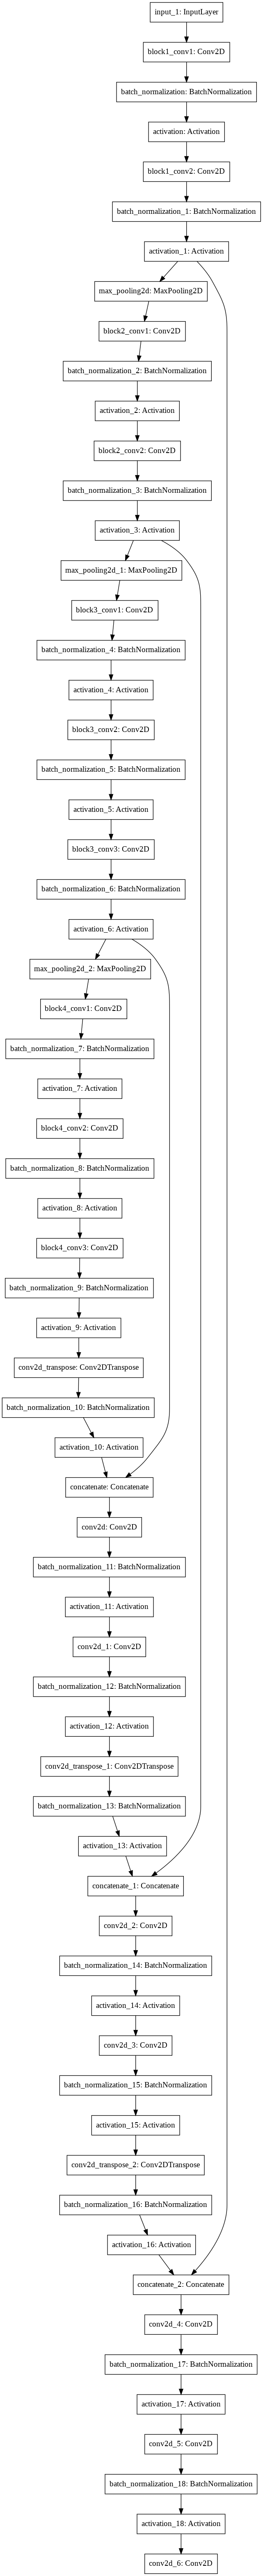

In [ ]:
#Формирование сети
modelunet1 = unet1(num_classes, (img_height, img_width, 3)) #Создание модели
modelunet1.summary() #Отображение содержания модели
plot_model(modelunet1, to_file='modelunet1.png') #Логическое отображение содержания модели

In [ ]:
#Обучение
historyunet1 = modelunet1.fit(xTrain, yTrain, epochs=10, batch_size=10, validation_data = (xVal, yVal)) #Обучение модели

Epoch 1/10
180/180 [==============================] - 421s 2s/step - loss: 0.1121 - dice_coef: 0.9349 - val_loss: 1.4910 - val_dice_coef: 0.7804
Epoch 2/10
180/180 [==============================] - 420s 2s/step - loss: 0.0976 - dice_coef: 0.9419 - val_loss: 0.8054 - val_dice_coef: 0.7891
Epoch 3/10
180/180 [==============================] - 420s 2s/step - loss: 0.0950 - dice_coef: 0.9439 - val_loss: 0.1181 - val_dice_coef: 0.9247
Epoch 4/10
180/180 [==============================] - 421s 2s/step - loss: 0.0880 - dice_coef: 0.9475 - val_loss: 0.0810 - val_dice_coef: 0.9499
Epoch 5/10
180/180 [==============================] - 424s 2s/step - loss: 0.0878 - dice_coef: 0.9476 - val_loss: 0.2516 - val_dice_coef: 0.8781
Epoch 6/10
180/180 [==============================] - 424s 2s/step - loss: 0.0847 - dice_coef: 0.9495 - val_loss: 0.0844 - val_dice_coef: 0.9488
Epoch 7/10
180/180 [==============================] - 424s 2s/step - loss: 0.0828 - dice_coef: 0.9505 - val_loss: 0.1941 - val_dic

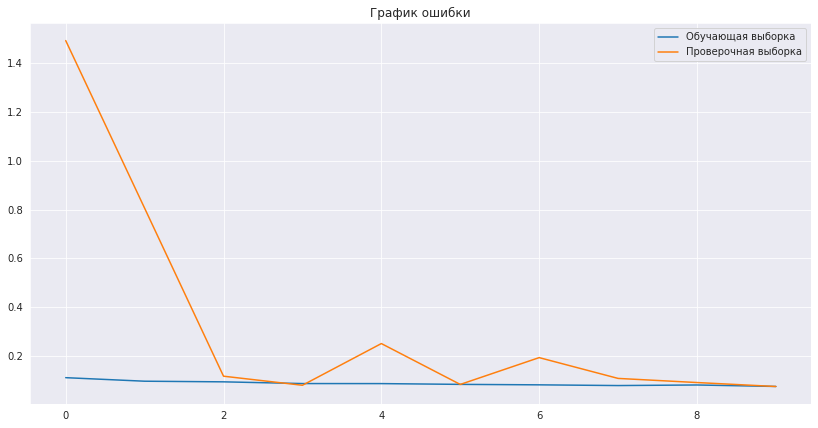

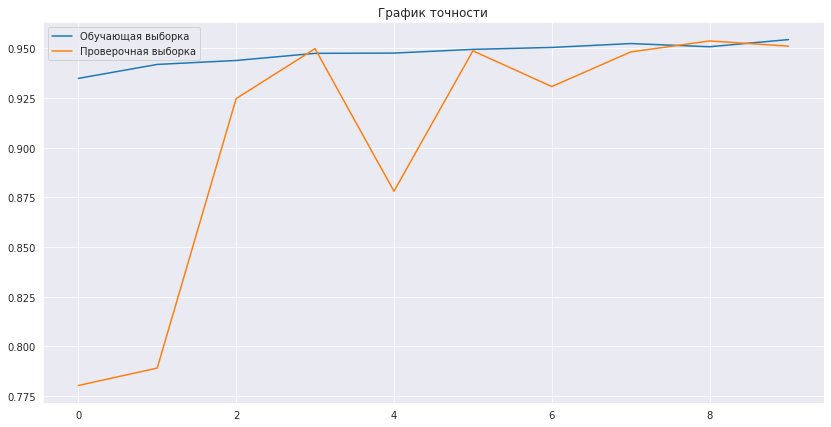

In [ ]:
#График ошибки
#loss - это значение функции потерь для обучающие выборки
#val_loss - это значение функции потерь с учетом проверочной выборки

plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historyunet1.history['loss'], label='Обучающая выборка')
plt.plot(historyunet1.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show() #Вывод полотна

#График точности
plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historyunet1.history['dice_coef'], label='Обучающая выборка')
plt.plot(historyunet1.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show() #Вывод полотна

In [ ]:
#Сохранение модели. Преобразование в JSON
modelunet1_json = modelunet1.to_json()
with open("/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet1.json", "w") as json_file:
  json_file.write(modelunet1_json)

In [ ]:
#Сохранение весов
modelunet1.save_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet1.h5')
#modelunet1.load_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet1.h5')

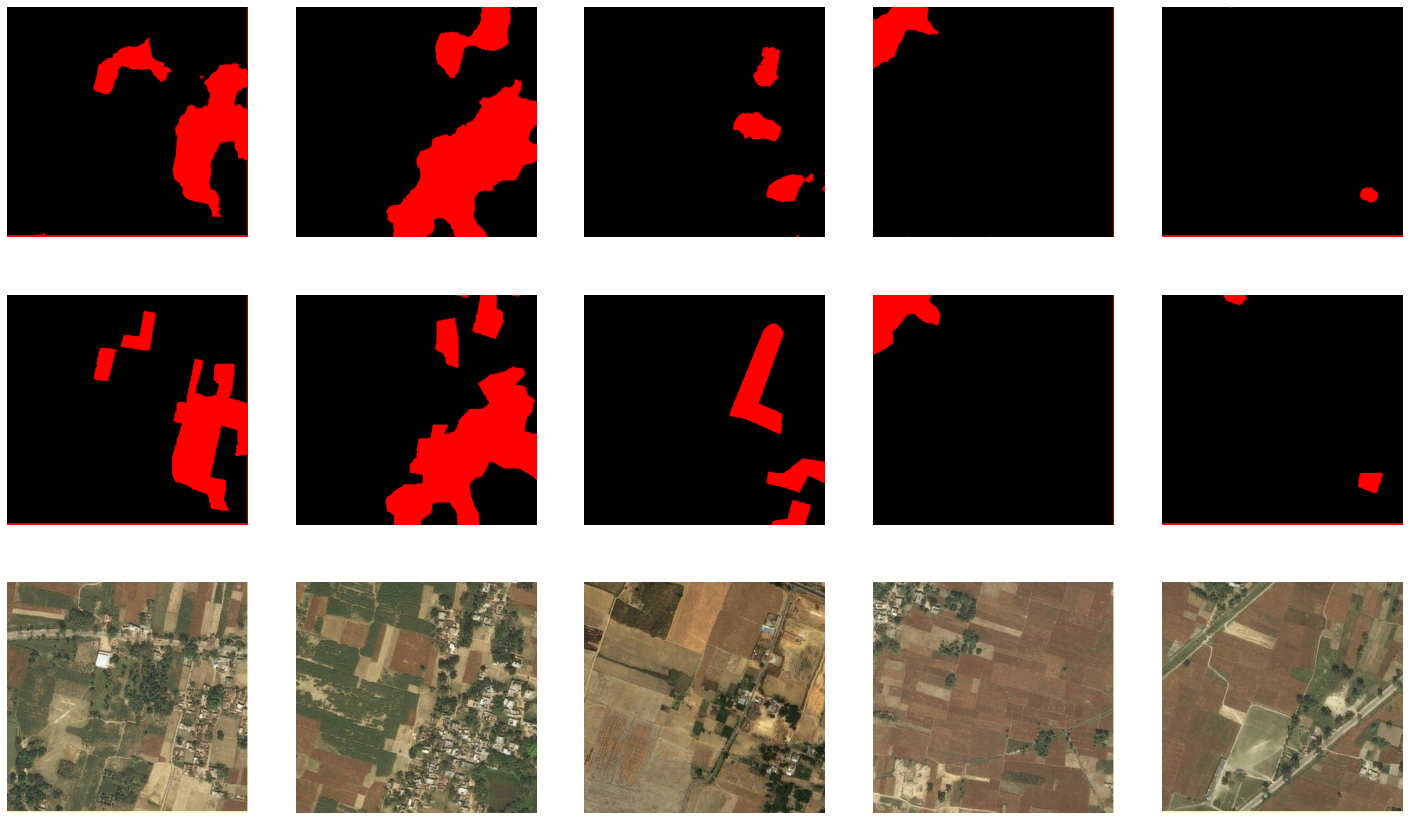

In [ ]:
#Проверка результата. Снизу-вверх: оригинал > сегментация исполнителя > предсказание нейросети
processImage(modelunet1, 5, num_classes)

# Unet 2 – усложнённая сеть

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 368, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 368, 384, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 368, 384, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 368, 384, 64) 0           batch_normalization_77[0][0]     
____________________________________________________________________________________________

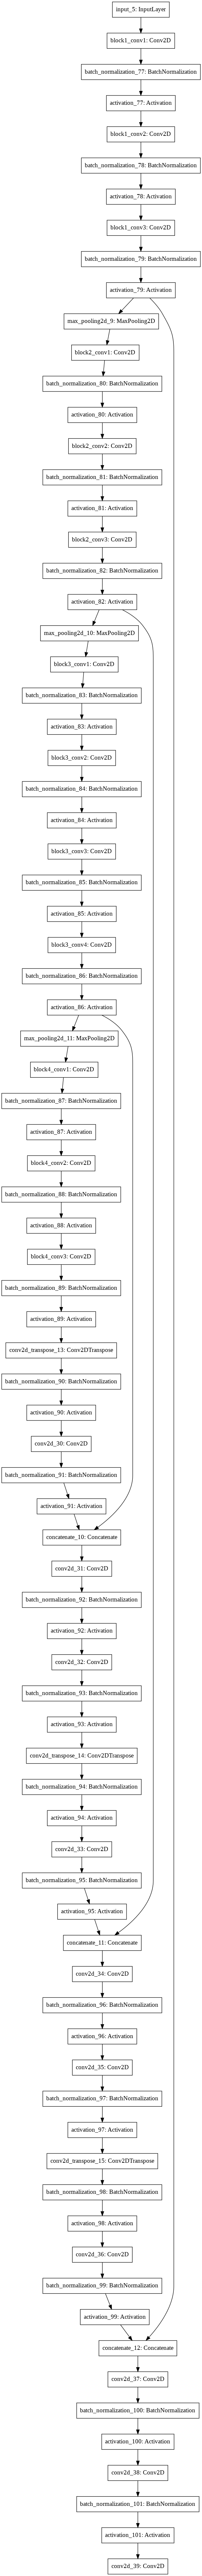

In [ ]:
#Сеть unet. Вариант 2
def unet2(num_classes, input_shape):
    img_input = Input(input_shape)

    #Down_1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных 
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(32, (2, 2), padding='same', name='block1_conv2')(x) #Двумерный сверточный слой, 32 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('elu')(x) #Слой функции активации Экспоненциальный линейный выпрямитель
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_1_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = MaxPooling2D()(block_1_out) #Двумерный слой уменьшения размерности в 2 раза

    #Down_2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(64, (2, 2), padding='same', name='block2_conv2')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('elu')(x) #Слой функции активации Экспоненциальный линейный выпрямитель
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv3')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_2_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = MaxPooling2D()(block_2_out) #Двумерный слой уменьшения размерности в 2 раза

    #Down_3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(128, (2, 2), padding='same', name='block3_conv2')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('elu')(x) #Слой функции активации Экспоненциальный линейный выпрямитель
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv4')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_3_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = MaxPooling2D()(block_3_out) #Двумерный слой уменьшения размерности в 2 раза

    #Down_Full
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x) #Двумерный сверточный слой, 512 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x) #Двумерный сверточный слой, 512 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x) #Двумерный сверточный слой, 512 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_4_out = Activation('relu')(x) #Слой функции активации Экспоненциальный линейный выпрямитель
    x = block_4_out 

    #Up_1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #Двумерный слой увеличения размерности в 2 раза
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(128, (2, 2), padding='same')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('elu')(x) #Слой функции активации Экспоненциальный линейный выпрямитель
    x = concatenate([x, block_3_out]) #Слой объединения
    x = Conv2D(256, (3, 3), padding='same')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(256, (3, 3), padding='same')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  

    #Up_3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) #Двумерный слой увеличения размерности в 2 раза
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(64, (2, 2), padding='same')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('elu')(x) #Слой функции активации Экспоненциальный линейный выпрямитель
    x = concatenate([x, block_2_out]) #Слой объединения
    x = Conv2D(128, (3, 3), padding='same')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(128, (3, 3), padding='same')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  

    #Up_3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) #Двумерный слой увеличения размерности в 2 раза
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(32, (2, 2), padding='same')(x) #Двумерный сверточный слой, 32 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('elu')(x) #Слой функции активации Экспоненциальный линейный выпрямитель
    x = concatenate([x, block_1_out]) #Слой объединения
    x = Conv2D(64, (3, 3), padding='same')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(64, (3, 3), padding='same')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель  
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) #Двумерный сверточный слой, 2 нейрона, с активацией категориального распределения

    model = Model(img_input, x) #Создание модели со входом img_input и выходом x   
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef]) #Компиляция модели
    return model

#Формирование сети
modelunet2 = unet2(num_classes, (img_height, img_width, 3)) #Создание модели
modelunet2.summary() #Отображение содержания модели
plot_model(modelunet2, to_file='modelunet2.png') #Логическое отображение содержания модели

In [ ]:
#Обучение
historyunet2 = modelunet2.fit(xTrain, yTrain, epochs=10, batch_size=10, validation_data = (xVal, yVal)) #Обучение модели

Epoch 1/10
180/180 [==============================] - 249s 1s/step - loss: 0.2102 - dice_coef: 0.8835 - val_loss: 0.3195 - val_dice_coef: 0.9081
Epoch 2/10
180/180 [==============================] - 242s 1s/step - loss: 0.1019 - dice_coef: 0.9389 - val_loss: 0.1323 - val_dice_coef: 0.9383
Epoch 3/10
180/180 [==============================] - 242s 1s/step - loss: 0.0903 - dice_coef: 0.9455 - val_loss: 0.0965 - val_dice_coef: 0.9407
Epoch 4/10
180/180 [==============================] - 242s 1s/step - loss: 0.0907 - dice_coef: 0.9461 - val_loss: 0.2633 - val_dice_coef: 0.9168
Epoch 5/10
180/180 [==============================] - 243s 1s/step - loss: 0.0903 - dice_coef: 0.9464 - val_loss: 0.0979 - val_dice_coef: 0.9403
Epoch 6/10
180/180 [==============================] - 242s 1s/step - loss: 0.0856 - dice_coef: 0.9487 - val_loss: 0.1547 - val_dice_coef: 0.9043
Epoch 7/10
180/180 [==============================] - 243s 1s/step - loss: 0.0832 - dice_coef: 0.9503 - val_loss: 0.0790 - val_dic

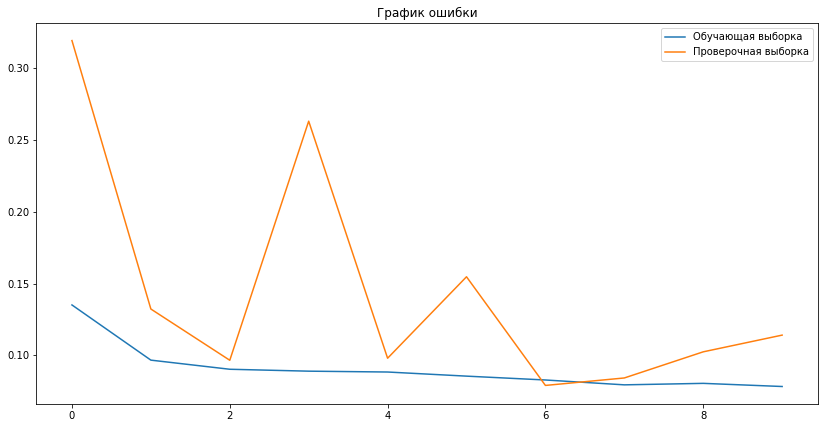

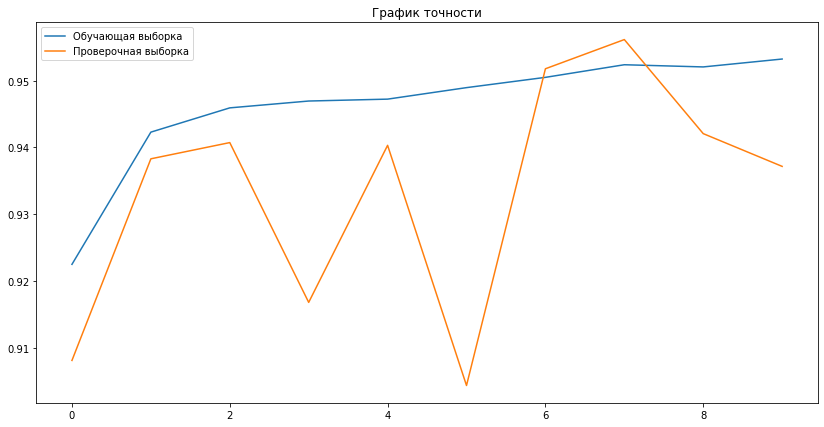

In [ ]:
#График ошибки
#loss - это значение функции потерь для обучающие выборки
#val_loss - это значение функции потерь с учетом проверочной выборки

plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historyunet2.history['loss'], label='Обучающая выборка')
plt.plot(historyunet2.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show() #Вывод полотна

#График точности
plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historyunet2.history['dice_coef'], label='Обучающая выборка')
plt.plot(historyunet2.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show() #Вывод полотна

In [ ]:
#Сохранение модели
modelunet2_json = modelunet2.to_json()
with open("/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet2.json", "w") as json_file:
  json_file.write(modelunet2_json)

#Сохранение весов
modelunet2.save_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet2.h5')
#modelunet2.load_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet2.h5')

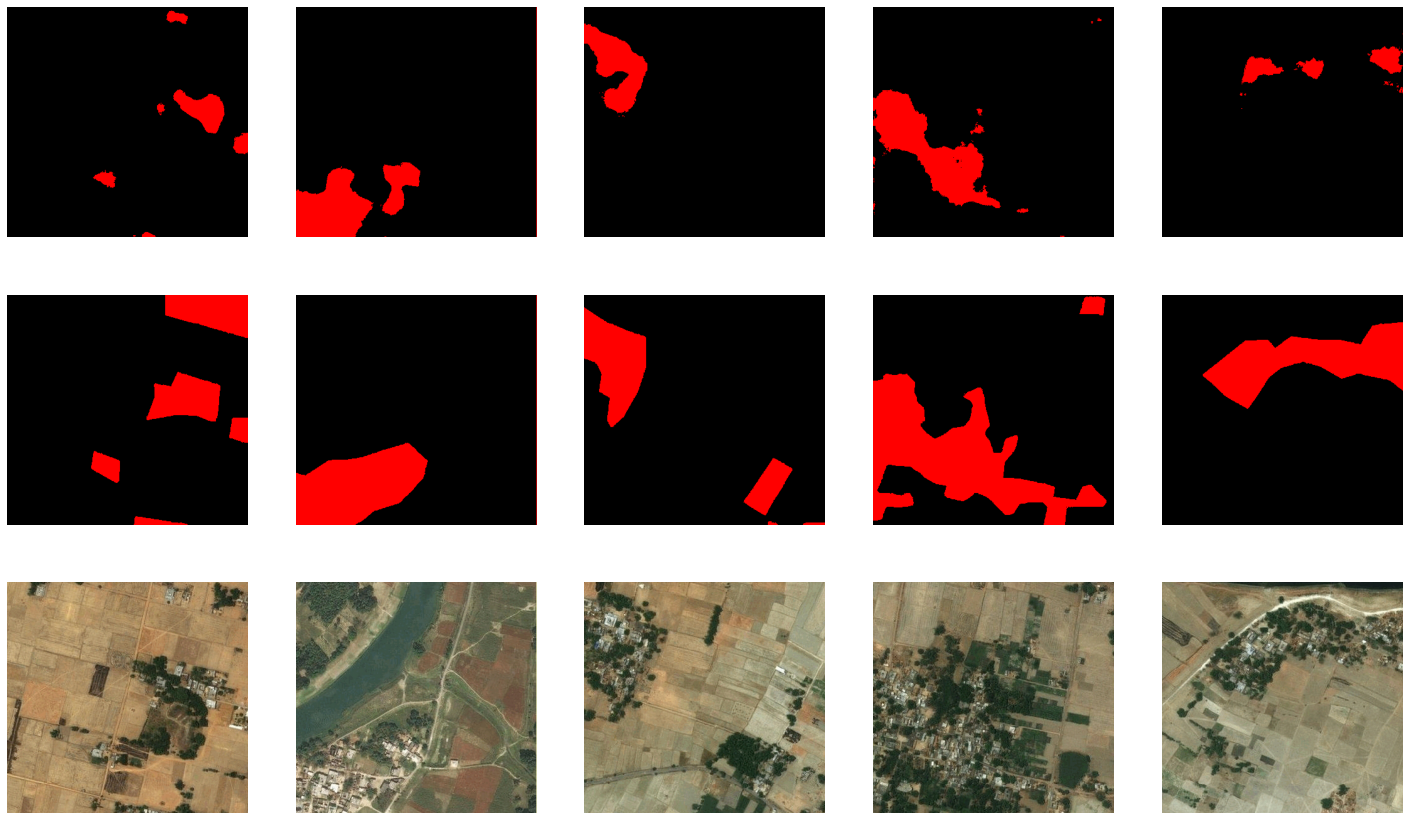

In [ ]:
#Проверка результата
processImage(modelunet2, 5, num_classes)

# Unet 3 – упрощённая сеть

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 368, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 368, 384, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_130 (BatchN (None, 368, 384, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_131 (Activation)     (None, 368, 384, 64) 0           batch_normalization_130[0][0]    
____________________________________________________________________________________________

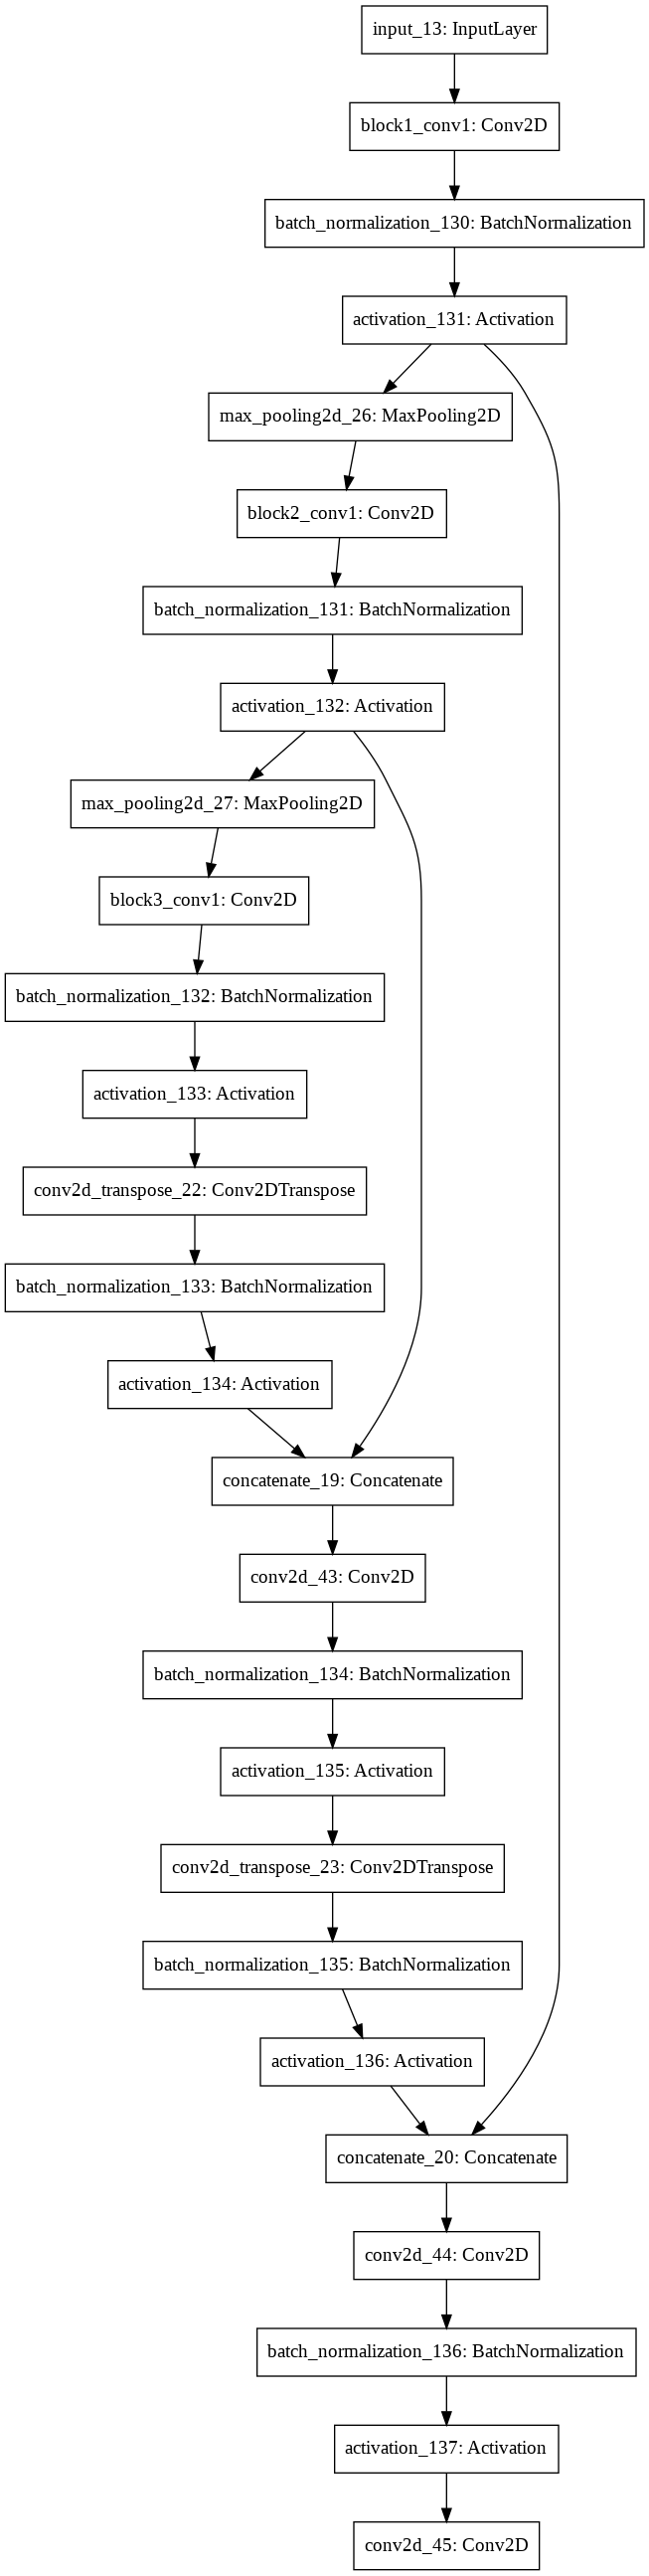

In [ ]:
#Сеть unet. Вариант 3
def unet3(num_classes, input_shape):
    img_input = Input(input_shape) #Входной слой с размерностью input_shape 

    #Down_1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_1_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = MaxPooling2D()(block_1_out) #Двумерный слой уменьшения размерности в 2 раза

    #Down_2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_2_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = MaxPooling2D()(block_2_out) #Двумерный слой уменьшения размерности в 2 раза

    #Down_Full
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x) #Двумерный сверточный слой, 256 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    block_3_out = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = block_3_out 

    #Up_1
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) #Двумерный слой увеличения размерности в 2 раза
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = concatenate([x, block_2_out]) #Слой объединения
    x = Conv2D(128, (3, 3), padding='same')(x) #Двумерный сверточный слой, 128 нейронов
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 

    #Up_2
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) #Двумерный слой увеличения размерности в 2 раза
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = concatenate([x, block_1_out]) #Слой объединения
    x = Conv2D(64, (3, 3), padding='same')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) #Двумерный сверточный слой, 2 нейрона

    model = Model(img_input, x) #Создание модели со входом img_input и выходом x  
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef]) #Компиляция модели
    return model

#Формирование сети
modelunet3 = unet3(num_classes, (img_height, img_width, 3)) #Создание модели
modelunet3.summary() #Отображение содержания модели
plot_model(modelunet3, to_file='modelunet3.png') #Логическое отображение содержания модели

In [ ]:
#Обучение
historyunet3 = modelunet3.fit(xTrain, yTrain, epochs=10, batch_size=10, validation_data = (xVal, yVal)) #Обучение модели

Epoch 1/10
180/180 [==============================] - 95s 516ms/step - loss: 0.2067 - dice_coef: 0.8832 - val_loss: 0.1497 - val_dice_coef: 0.9145
Epoch 2/10
180/180 [==============================] - 96s 536ms/step - loss: 0.1141 - dice_coef: 0.9335 - val_loss: 0.1237 - val_dice_coef: 0.9355
Epoch 3/10
180/180 [==============================] - 99s 548ms/step - loss: 0.1055 - dice_coef: 0.9390 - val_loss: 0.1715 - val_dice_coef: 0.9235
Epoch 4/10
180/180 [==============================] - 99s 548ms/step - loss: 0.1045 - dice_coef: 0.9400 - val_loss: 0.1220 - val_dice_coef: 0.9437
Epoch 5/10
180/180 [==============================] - 99s 550ms/step - loss: 0.1034 - dice_coef: 0.9401 - val_loss: 0.1488 - val_dice_coef: 0.9243
Epoch 6/10
180/180 [==============================] - 99s 549ms/step - loss: 0.1000 - dice_coef: 0.9420 - val_loss: 0.1008 - val_dice_coef: 0.9383
Epoch 7/10
180/180 [==============================] - 99s 549ms/step - loss: 0.1084 - dice_coef: 0.9370 - val_loss: 0.

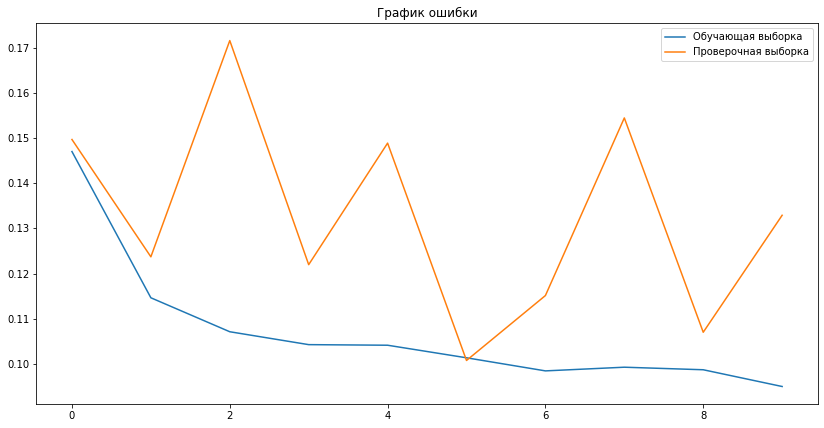

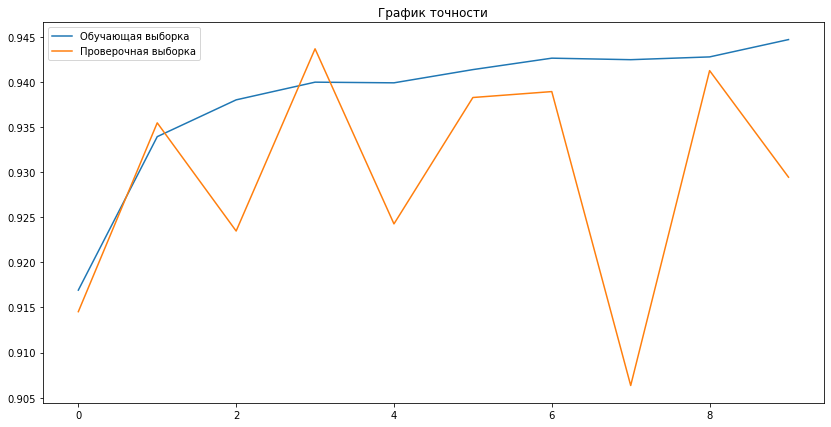

In [ ]:
#График ошибки
#loss - это значение функции потерь для обучающие выборки
#val_loss - это значение функции потерь с учетом проверочной выборки

plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historyunet3.history['loss'], label='Обучающая выборка')
plt.plot(historyunet3.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show() #Вывод полотна

#График точности
plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historyunet3.history['dice_coef'], label='Обучающая выборка')
plt.plot(historyunet3.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show() #Вывод полотна

In [ ]:
#Сохранение модели. Преобразование в JSON
modelunet3_json = modelunet3.to_json()
with open("/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet3.json", "w") as json_file:
  json_file.write(modelunet3_json)

#Сохранение весов
modelunet3.save_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet3.h5')
#modelunet3.load_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelunet3.h5')

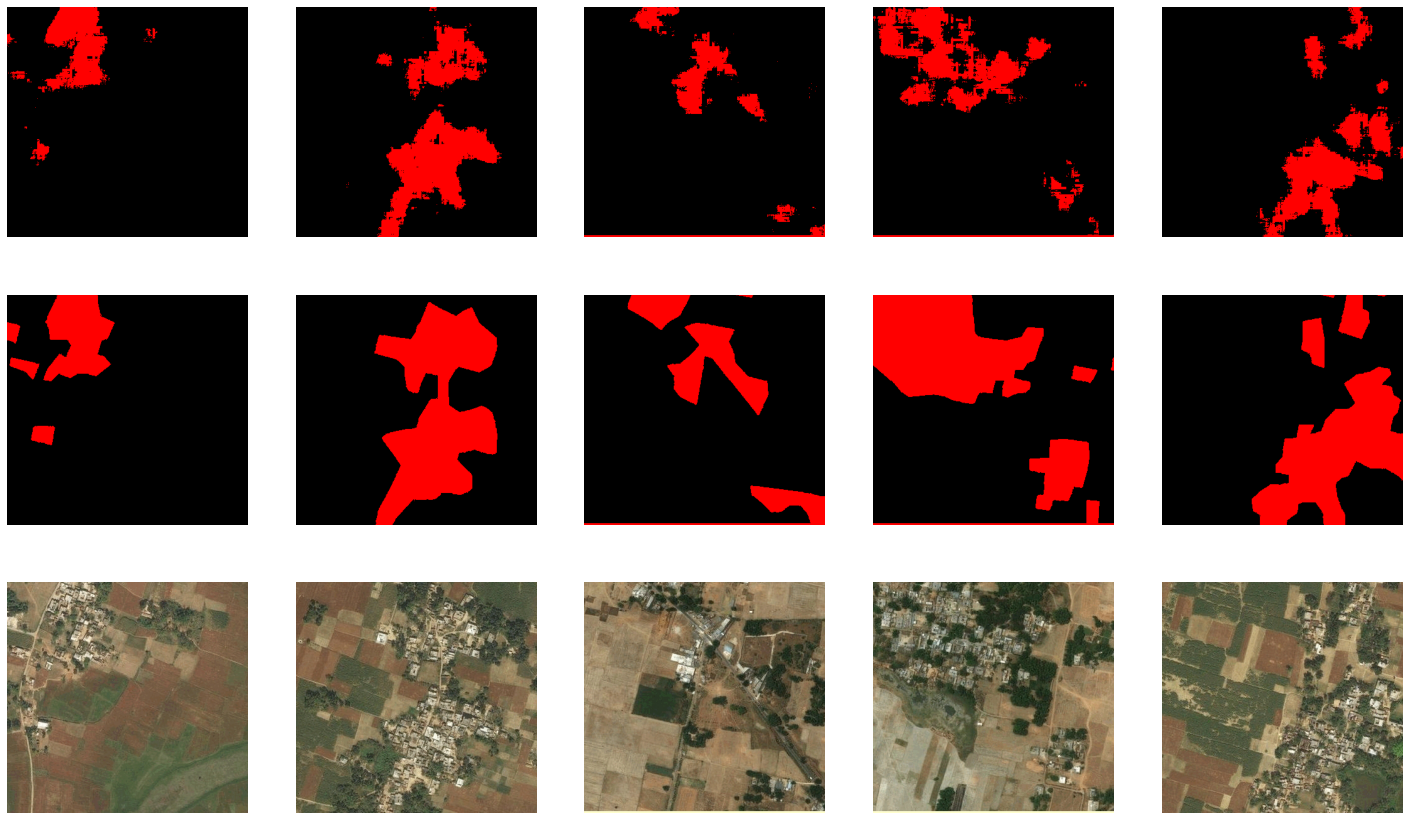

In [ ]:
#Проверка результата. Снизу-вверх: оригинал > сегментация исполнителя > предсказание нейросети
processImage(modelunet3, 5, num_classes)

# Блок 3 PSPnet

In [ ]:
#Сеть psp
def pspnet1(num_classes, input_shape):
    img_input = Input(input_shape) #Входной слой с размерностью input_shape                                        

    x = Conv2D(64, (3, 3), padding='same', name='conv1')(img_input) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных                                         
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных 
    forpool = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 

    pool1 = MaxPooling2D(pool_size=(2, 2), padding="same", name='pool1')(forpool) #Двумерный слой уменьшения размерности в 2 раза
    transp1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(pool1) #Двумерный слой увеличения размерности в 2 раза
    transp1 = BatchNormalization()(transp1) #Слой нормализации входных данных                                        
    transp1 = Activation('relu')(transp1) #Слой функции активации Линейный выпрямитель 

    pool2 = MaxPooling2D(pool_size=(4, 4), padding="same", name='pool2')(forpool) #Двумерный слой уменьшения размерности в 2 раза
    transp2 = Conv2DTranspose(256, (4, 4), strides=(4, 4), padding='same')(pool2) #Двумерный слой увеличения размерности в 2 раза
    transp2 = BatchNormalization()(transp2) #Слой нормализации входных данных                                        
    transp2 = Activation('relu')(transp2) #Слой функции активации Линейный выпрямитель 

    pool3 = MaxPooling2D(pool_size=(8, 8), padding="same", name='pool3')(forpool) #Двумерный слой уменьшения размерности в 2 раза
    transp3 = Conv2DTranspose(256, (8, 8), strides=(8, 8), padding='same')(pool3) #Двумерный слой увеличения размерности в 2 раза
    transp3 = BatchNormalization()(transp3) #Слой нормализации входных данных                                        
    transp3 = Activation('relu')(transp3) #Слой функции активации Линейный выпрямитель 

    pool4 = MaxPooling2D(pool_size=(16, 16), padding="same", name='pool4')(forpool) #Двумерный слой уменьшения размерности в 2 раза
    transp4 = Conv2DTranspose(256, (16, 16), strides=(16, 16), padding='same')(pool4) #Двумерный слой увеличения размерности в 2 раза
    transp4 = BatchNormalization()(transp4) #Слой нормализации входных данных                                       
    transp4 = Activation('relu')(transp4) #Слой функции активации Линейный выпрямитель 

    x = concatenate([transp1, transp2, transp3, transp4]) #Слой объединения
    x = Conv2D(64, (3, 3), padding='same')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных                                       
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = Conv2D(64, (3, 3), padding='same')(x) #Двумерный сверточный слой, 64 нейрона
    x = BatchNormalization()(x) #Слой нормализации входных данных                                       
    x = Activation('relu')(x) #Слой функции активации Линейный выпрямитель 
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) #Двумерный сверточный слой, 2 нейрона, с активацией категориального распределения

    model = Model(img_input, x) #Создание модели со входом img_input и выходом x 
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef]) #Компиляция модели
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 368, 384, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 368, 384, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 368, 384, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 368, 384, 64) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

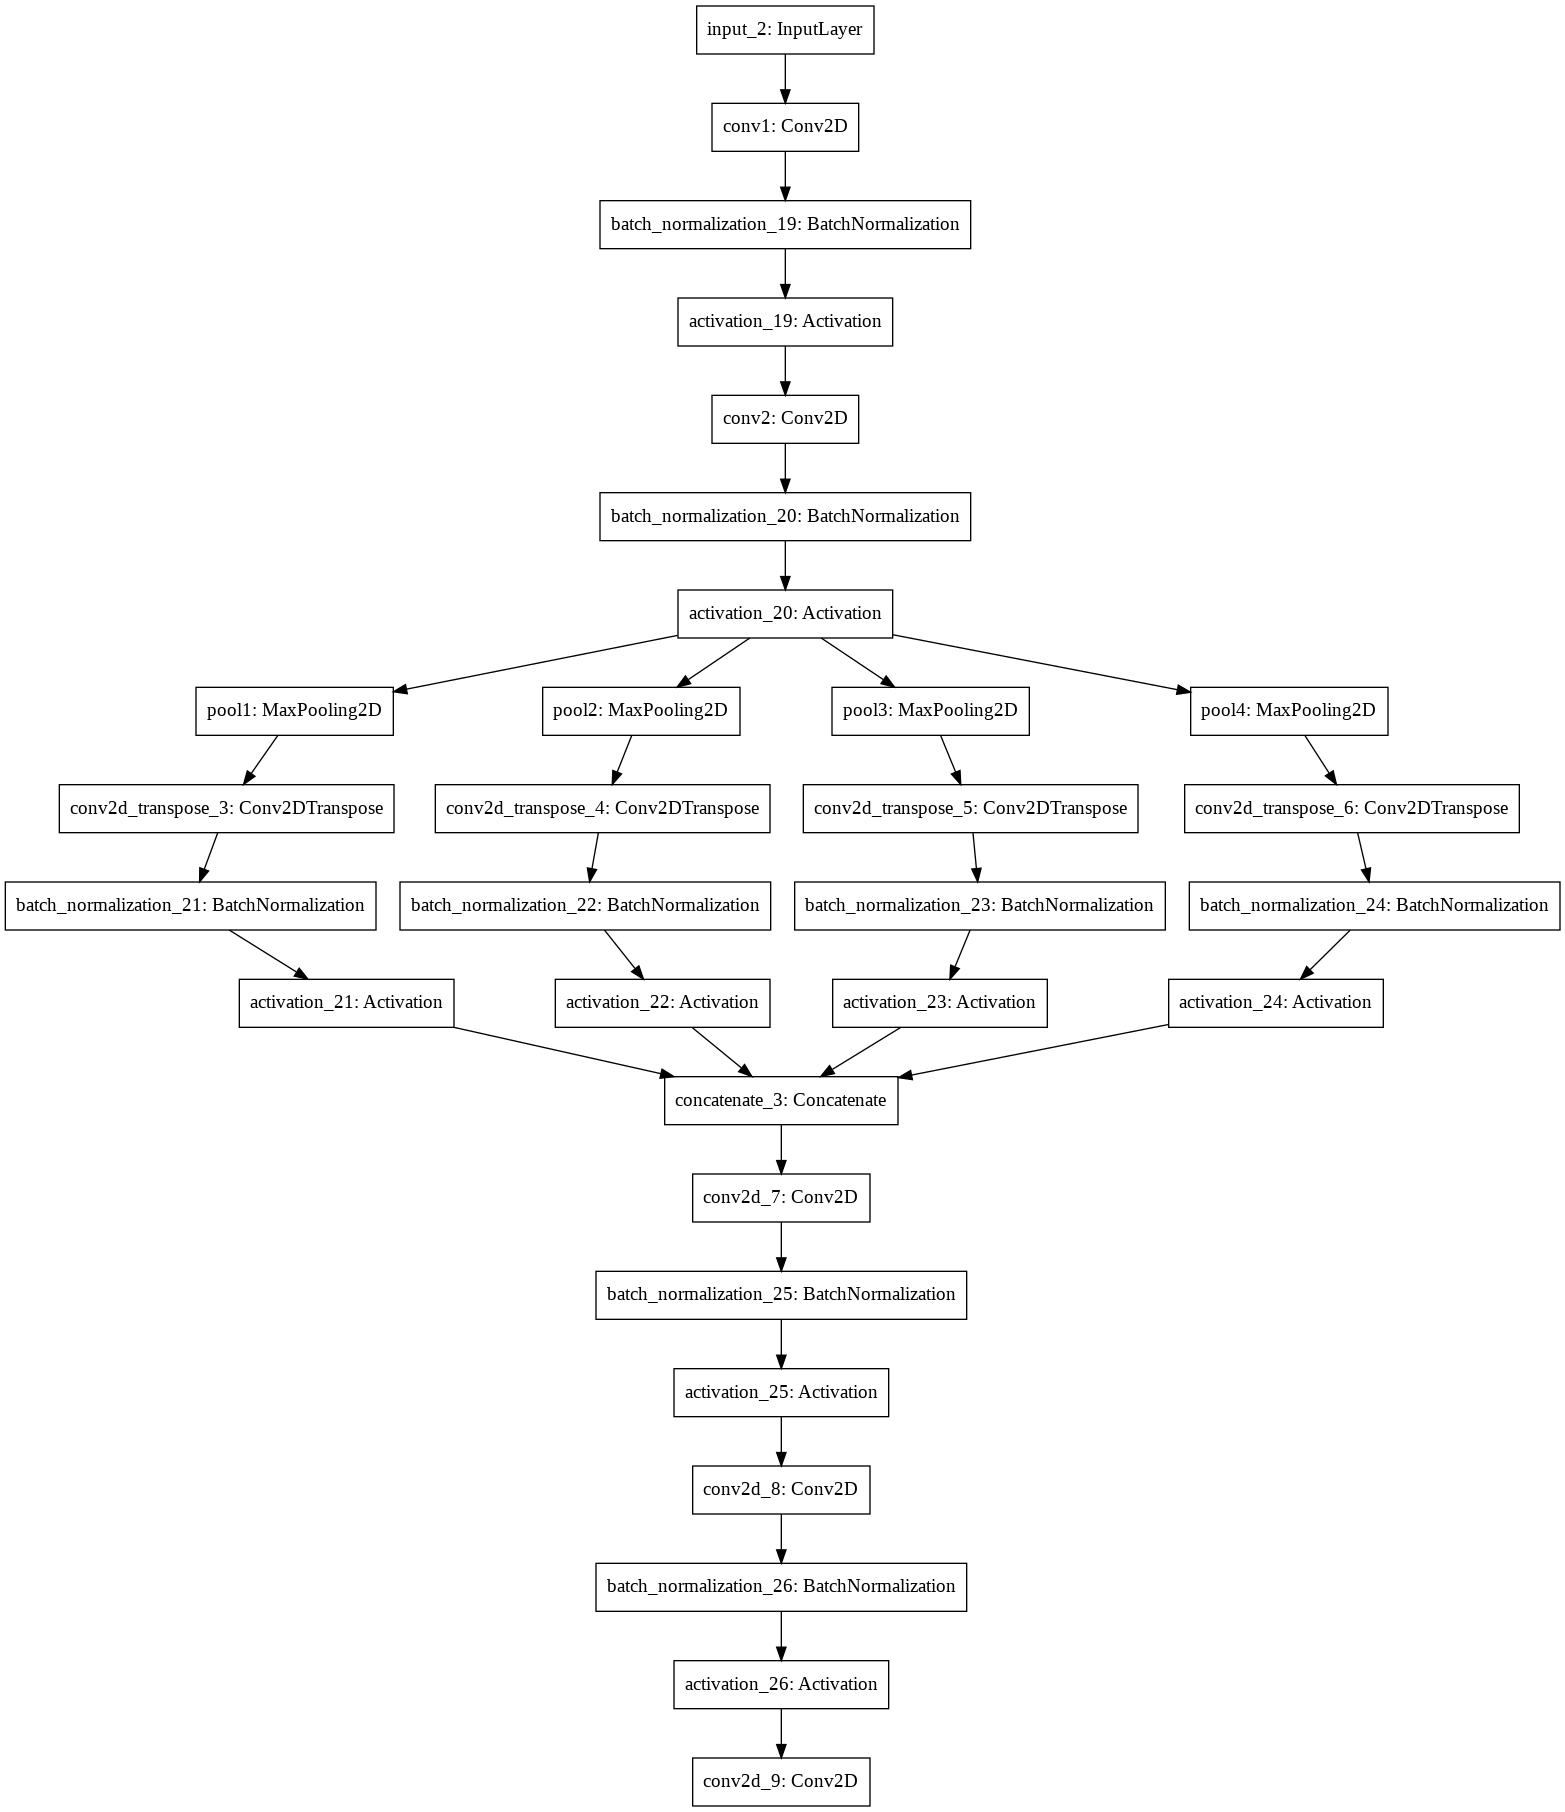

In [ ]:
#Формирование сети
modelpspnet1 = pspnet1(num_classes, (img_height, img_width,3)) #Создание модели
modelpspnet1.summary() #Отображение содержания модели
plot_model(modelpspnet1, to_file='modelpspnet1.png') #Логическое отображение содержания модели

In [ ]:
#Обучение
historypspnet1 = modelpspnet1.fit(xTrain, yTrain, epochs=10, batch_size=4, validation_data = (xVal, yVal)) #Обучение модели

Epoch 1/10
450/450 [==============================] - 506s 1s/step - loss: 0.1476 - dice_coef: 0.9164 - val_loss: 0.2058 - val_dice_coef: 0.9077
Epoch 2/10
450/450 [==============================] - 509s 1s/step - loss: 0.1330 - dice_coef: 0.9247 - val_loss: 0.2389 - val_dice_coef: 0.9125
Epoch 3/10
450/450 [==============================] - 509s 1s/step - loss: 0.1248 - dice_coef: 0.9289 - val_loss: 0.1834 - val_dice_coef: 0.9216
Epoch 4/10
450/450 [==============================] - 509s 1s/step - loss: 0.1217 - dice_coef: 0.9302 - val_loss: 0.2723 - val_dice_coef: 0.9095
Epoch 5/10
450/450 [==============================] - 509s 1s/step - loss: 0.1201 - dice_coef: 0.9314 - val_loss: 0.1135 - val_dice_coef: 0.9399
Epoch 6/10
450/450 [==============================] - 509s 1s/step - loss: 0.1151 - dice_coef: 0.9344 - val_loss: 0.1507 - val_dice_coef: 0.9336
Epoch 7/10
450/450 [==============================] - 509s 1s/step - loss: 0.1146 - dice_coef: 0.9342 - val_loss: 0.2861 - val_dic

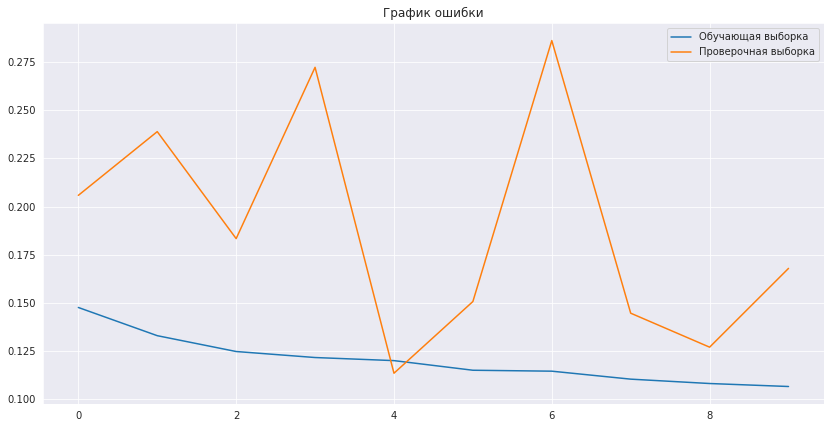

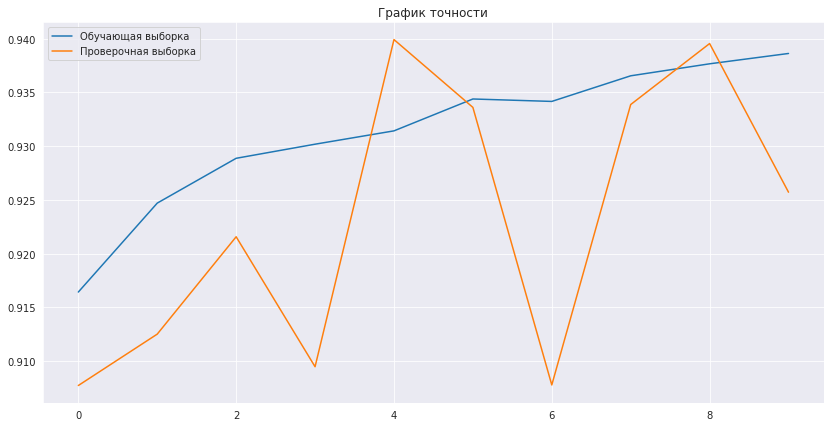

In [ ]:
#График ошибки
#loss - это значение функции потерь для обучающие выборки
#val_loss - это значение функции потерь с учетом проверочной выборки

plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historypspnet1.history['loss'], label='Обучающая выборка')
plt.plot(historypspnet1.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show() #Вывод полотна

#График точности
plt.figure(figsize=(14,7)) #Настройка полотна
plt.plot(historypspnet1.history['dice_coef'], label='Обучающая выборка')
plt.plot(historypspnet1.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show() #Вывод полотна

In [ ]:
#Сохранение модели. Преобразование в JSON
modelpspnet1_json = modelpspnet1.to_json()
with open("/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelpspnet1.json", "w") as json_file:
  json_file.write(modelpspnet1_json)

In [ ]:
# Сохранение весов
modelpspnet1.save_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelpspnet1.h5')
#modelpspnet1.load_weights('/content/drive/My Drive/Segmentation_Urban_Area/Weights/modelpspnet1.h5')

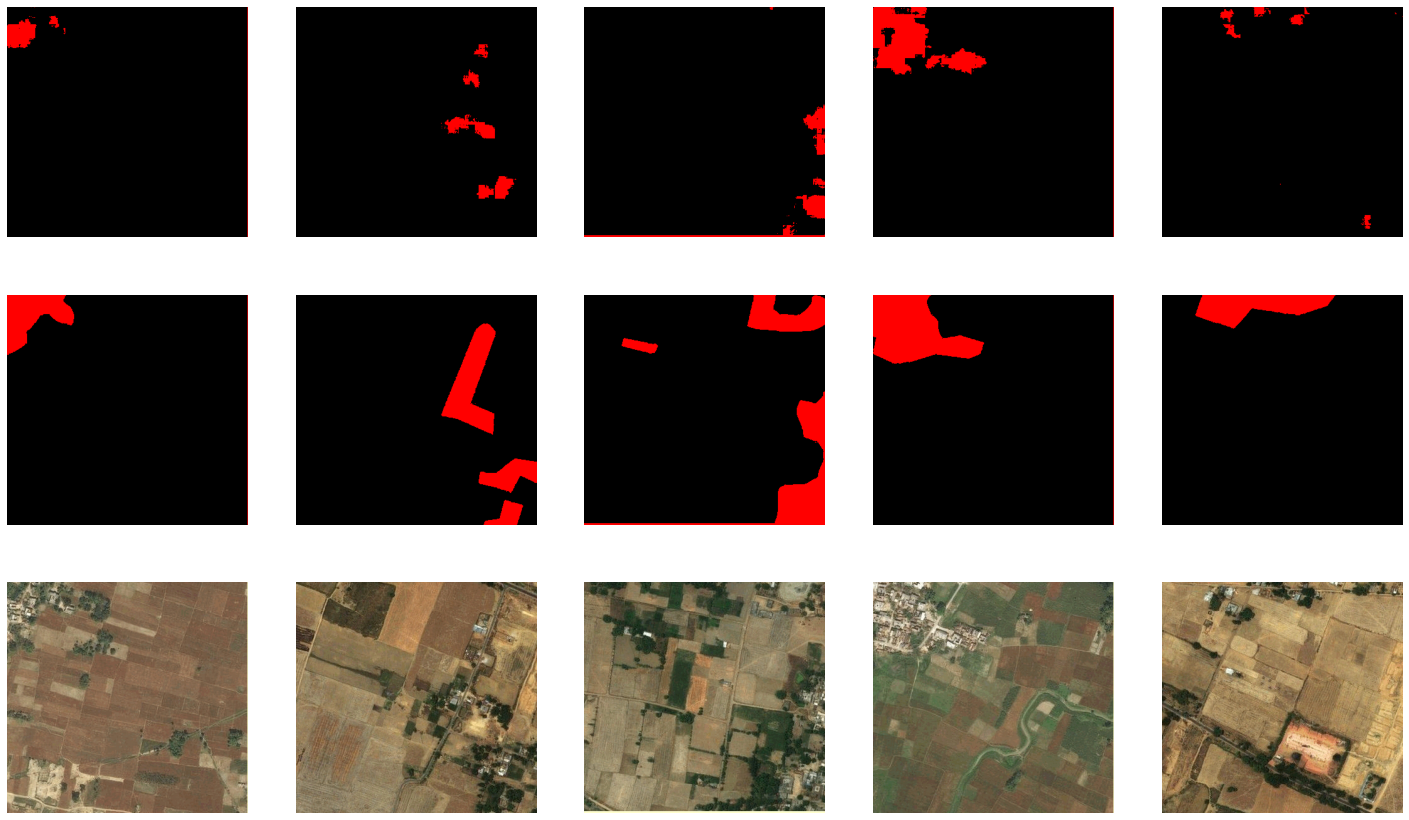

In [ ]:
#Проверка результата. Снизу-вверх: оригинал > сегментация исполнителя > предсказание нейросети
processImage(modelpspnet1, 5, num_classes)

# Выбор архитектуры сети

Сети работают точнее исполнителя

Оценка (1 - лучший результат):

1.   Unet 1. Точность 95.1 %
2.   Unet 2. Точность 93.7 %
3.   Unet 3. Точность 92.9 %
4.   PSPnet. Точность 92.6 %
5.   Linear net 2. Точность 91.3 %
6.   Linear net 1. Точность 89.1 %

**Вывод:**
*   Архитектура Unet 1 средней сложности оптимальна для сегментации выбранных космических снимков

# Интеграция в производство

In [ ]:
#Скрипт для использования без специального визуального интерфейса
#На входе растр GeoTIFF
#На выходе ESRi Shapefile

import os, sys, shutil, subprocess #Работа с файловой системой, интерпретатором python
from pathlib import Path #Работа с путями

#Работа с пространственными данными
from osgeo import gdal, ogr, osr #Инструменты географического анализа
from shapely import speedups #Инструменты производительности
from shapely.geometry import shape, mapping #Инструменты работы с геометрией
from shapely.ops import unary_union #Инструмент объединения
import fiona #Чтение файлов с географической привязкой
import geopandas #Инструменты географического анализа векторных данных

#Работа с библиотекой keras нейросетевой обработки данных
from tensorflow.keras.models import Model, model_from_json #Методы создания и загрузки модели
from tensorflow.keras import backend as K #Модуль внутрисистемной разработки
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.preprocessing import image #Модуль для работы с изображениями

import itertools #Работа с последовательностями
from operator import itemgetter #Работа с последовательностями

import numpy as np #Работа со специальными массивами
import pandas #Работа с таблицами

from PIL import Image #Работа с изображениями

#Данные----------------------------------------------
#Главные паременные
path = "C:/Users/User/Desktop/" #Директория с входным растром 
filename = "GEOTIFF.tif" #Имя входной растра
shapefilepath = "C:/Users/User/Desktop/out/" #Директория выходного векторного файла
shapefilename = "shapefile" #Имя выходного векторного файла
modelpath = "C:/Users/User/Desktop/ModelData/" #Директория с моделью
modeljsonname= "modellinearnet1.json" #Имя файла модели
modelwightsname = "modellinearnet1.h5" #Имя файла весов

#Вспомогательные паременные
num_classes = 2 #Количество классов 
epsg = 4326 #Код проекции
filenamereproject = filename.split(".")[0] + "_reproject" + "." + filename.split(".")[1] #Имя перепроецированного растра
filenamesplit = "split_" #Тег тайла при разделении
img_width = 384 #Ширина тайла
img_height = 368 #Высота тайла
filestartswith = "split" #Параметр поиска 1
fileendswith = '.tif' #Параметр поиска 2
techdirmain = path + "technicalfolderforwork" #Основаная техническая директория 
techdirin1 = techdirmain + "/" + "split" + "/" #Техническая директория для разделения 
techdirin2 = techdirmain + "/" + "predict" + "/" #Техническая директория для предсказания
techdirin3 = techdirmain + "/" + "shape" + "/" #Техническая директория для конвертации
#Данные----------------------------------------------

#Функции-----------------------------------------
#Функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) #Определение площади пересечения, деленную на площадь объединения двух областей

#Функция преобразования индекса в цвет пикселя
#Если индекс 0 - то черный цвет, если индекс 1 - то красный
def index2color(index2):
  index = np.argmax(index2) #Получение индекса максимального элемента
  color = [] #Создание массива для записи чистого цвета
  if index == 0:
    color = [0, 0, 0] #Черный для записи фона
  elif index == 1:
    color = [255, 0, 0] #Красный для записи урбанизированных территорий
  return color #Вывод одномерного массива

#Функция копирование файлового дерева
def copytree(src, dst, symlinks=False, ignore=None):
    if not os.path.exists(dst): #Создать папку при отсутствии
        os.makedirs(dst)
    for item in os.listdir(src):
        s = os.path.join(src, item) #Обработка входа
        d = os.path.join(dst, item) #Обработка выхода
        if os.path.isdir(s): 
            copytree(s, d, symlinks, ignore) #Копирование
        else:
            if not os.path.exists(d) or os.stat(s).st_mtime - os.stat(d).st_mtime > 1:
                shutil.copy2(s, d) #Копирование

#Функция обработки изображения
def processimage(model, filenamein, filenameout, n_classes):
    img = image.load_img(os.path.join(techdirin2,filenamein), target_size=(img_height, img_width)) #Загрузка изображения
    xTest = image.img_to_array(img) #Преобразование изображения в массив
    predict = np.array(model.predict(xTest.reshape(1, img_height, img_width, 3))) #Предсказание
    pr = predict[0] #Нулевой элемент из предсказания [1, высота, ширина, каналы]
    pr = pr.reshape(-1, n_classes) #Изменение размерности предсказания [высота * ширина, каналы]
    pr1 = [] #Создание массива под сегментированное изображение из предсказания

    for k in range(len(pr)): #Проход по количеству классов
        pr1.append(index2color(pr[k])) #Запись перевода индекса в пиксель

    pr1 = np.array(pr1) #Преобразование в numpy-массив
    pr1 = pr1.reshape(img_height, img_width, 3) #Довод к размерности изображения   
    readyimg = Image.fromarray(pr1.astype('uint8')) #Преобразование массива в изображение
    readyimg.save(techdirin2+filenameout) #Сохранение изображения                

#Функция конвертации в Shaprfile   
def converttoshapefile(image):
    name = str(image).split(".")[0] #Параметр поиска растра, имя файла
    raster_path = techdirin2 + image #Параметр поиска растра, директория
    shapefile_path = techdirin3 + name + ".shp" #Параметр выходного векторного файла, директория   
    
    sourceRaster = gdal.Open(raster_path) #Чтение растра
    band = sourceRaster.GetRasterBand(1) #Чтение первого канала
    outShapefile = "polygonized" #Метка преобразования
    driver = ogr.GetDriverByName("ESRI Shapefile") #Метка расширения
    dest_srs = osr.SpatialReference() #Метка проекции. Создать запись
    dest_srs.ImportFromEPSG(epsg) #Метка проекции. Взять из базы
    
    if os.path.exists(shapefile_path): #Предварительная файловая очистка
        driver.DeleteDataSource(shapefile_path)
    outDatasource = driver.CreateDataSource(shapefile_path) #Создание файла
    outLayer = outDatasource.CreateLayer("polygonized", srs=dest_srs) #Создание полигонального слоя
    gdal.Polygonize( band, band, outLayer, 0, [], callback=None ) #Запись и маскироввание
    outDatasource.Destroy() #Закончить запись
    sourceRaster = None

#Функия слияния (Dissolve)
#dissolve(shp1, shp2, ["FIELD1", "FIELD2", "FIELDN"])    
def dissolve(input, output, fields):
    with fiona.open(input) as input: #Загрузка файла и параметров
        with fiona.open(output, 'w', **input.meta) as output:
            grouper = itemgetter(*fields) #Создание массива данных полей
            key = lambda k: grouper(k['properties']) #Обработка геометрии и записей
            for k, group in itertools.groupby(sorted(input, key=key), key):
                properties, geom = zip(*[(feature['properties'], shape(feature['geometry'])) for feature in group])
                output.write({'geometry': mapping(unary_union(geom)), 'properties': properties[0]})    
#Функции-----------------------------------------

#1. Подготовка
if os.path.exists(techdirmain): #Удаление основной технической папки при наличии
    shutil.rmtree(techdirmain) 
    
#2. Создание структуры технических папок и перепроецирование входного растра
if not os.path.exists(techdirmain):
    os.mkdir(techdirmain) #Создание основной директории
    os.mkdir(techdirin1) #Создание директории
    os.mkdir(techdirin3) #Создание директории
subprocess.check_call('gdalwarp ' + path + filename + ' ' + path + filenamereproject + ' -t_srs "+proj=longlat +ellps=WGS84"') #Проецирование растра


#3. Разбивка изображения на тайлы
ds = gdal.Open(path + filenamereproject) #Загрузка входного растра
band = ds.GetRasterBand(1) #Загрузка первого канала
xsize = band.XSize #Ширина канала
ysize = band.YSize #Высота канала
for i in range(0, xsize, img_width): #Проход по ширине входного растра окном заданной ширины  
    for j in range(0, ysize, img_height): #Проход по высоте входного растра окном заданной высоты
        com_string = "gdal_translate -of GTIFF -co TFW=yes -srcwin " + str(i)+ ", " + str(j) + ", " + str(img_width) + ", " + str(img_height) + " " + str(path) + str(filenamereproject) + " " + str(techdirin1) + str(filenamesplit) + str(i) + "_" + str(j) + ".tif" #Команда разделения входного растра в GeoTIFF тайлы
        subprocess.check_call(com_string) #Выполнение команды через командную строку

#4. Копирование папки с тайлами
copytree(techdirin1, techdirin2, symlinks=False, ignore=None) #Копирование директории с тайлами

#5. Загрузка модели сети
model_json_file = open(modelpath + modeljsonname,"r") #Загрузка файла модели
loaded_model_json = model_json_file.read() #Чтение файла модели
model_json_file.close() #Закрытие файла модели
loaded_model = model_from_json(loaded_model_json) #Загрузка модели
loaded_model.load_weights(modelpath + modelwightsname) #Загрузка весов
loaded_model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=[dice_coef]) #Компиляция модели

#6. Сегментация     
filelist = os.listdir(techdirin2) #Открытие директории с растрами
for file in filelist: #Проход по файлам
    if file.startswith(filestartswith) and file.endswith(fileendswith):
        processimage(loaded_model, str(file), str(file), num_classes) #Преобразование с предсказанием
        
#7. Конвертирование в набор векторных файлов .shp
newfilelist = os.listdir(techdirin2) #Открытие директории с растрами
for newfile in newfilelist: #Проход по файлам
    if newfile.startswith(filestartswith) and newfile.endswith(fileendswith):
        converttoshapefile(str(newfile)) #Конвертация предсказания в векторные файлы

#8. Объединение векторных файлов
speedups.disable() #Отключить ускорение производительности
shapefolder = Path(techdirin3) #Чтение директории с векторными файлами
shapefiles = shapefolder.glob("*.shp") #Чтение файлов с указанным расширением
gdf = pandas.concat([
    geopandas.read_file(shp)
    for shp in shapefiles
]).pipe(geopandas.GeoDataFrame) #Объединение записей
gdf.to_file(techdirmain +"/"+ shapefilename +".shp") #Преобразование в файл

outshp = geopandas.read_file(techdirmain +"/" + shapefilename +".shp") #Чтение объединенного файла
outshp["value"] = 1 #Создание нового поля
outshp.to_file(techdirmain +"/"+ shapefilename + ".shp") #Преобразование в файл

#9. Слияние объектов
dissolve(techdirmain +"/"+ shapefilename + ".shp", shapefilepath + shapefilename + ".shp", ["value"]) #слияние в один объект по одинаковым значениям поля value

#10. Удаление технической папки
shutil.rmtree(techdirmain) #удаление технических директорий

In [ ]:
#Скрипт для работы с элементами интерфейса среды QGIS
#На входе растр GeoTIFF
#На выходе ESRi Shapefile

#Подключение стандартных библиотек QGIS для работы с интерфейсом, директориями, векторными и растровыми слоями
from qgis.PyQt.QtCore import QCoreApplication
from qgis.core import (QgsProcessing,
                       QgsFeatureSink,
                       QgsProcessingException,
                       QgsProcessingAlgorithm,
                       QgsMessageLog,
                       QgsProcessingParameterFeatureSource,
                       QgsProcessingParameterFeatureSink,
                       QgsProcessingParameterRasterLayer,
                       QgsProcessingParameterVectorDestination,
                       QgsProcessingParameterFolderDestination,
                       QgsProcessingParameterString,
                       QgsProject,
                       QgsVectorLayer,
                       QgsRasterLayer
                       )
from qgis import processing

import os, sys, shutil, subprocess #Работа с файловой системой, интерпретатором python
from pathlib import Path #Работа с путями

#Работа с пространственными данными
from osgeo import gdal, ogr, osr #Инструменты географического анализа
from shapely import speedups #Инструменты производительности
from shapely.geometry import shape, mapping #Инструменты работы с геометрией
from shapely.ops import unary_union #Инструмент объединения
import fiona #Чтение файлов с географической привязкой
import geopandas #Инструменты географического анализа векторных данных

#Работа с библиотекой keras нейросетевой обработки данных
from tensorflow.keras.models import Model, model_from_json #Методы создания и загрузки модели
from tensorflow.keras import backend as K #Модуль внутрисистемной разработки
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.preprocessing import image #Модуль для работы с изображениями

import itertools #Работа с последовательностями
from operator import itemgetter #Работа с последовательностями

import numpy as np #Работа со специальными массивами
import pandas #Работа с таблицами
import re #Работа с регулярными выражениями

from PIL import Image #Работа с изображениями

#Выполнение внутри специального класса
class ExampleProcessingAlgorithm(QgsProcessingAlgorithm):

    #Главные переменные
    INPUT = 'INPUT'
    OUTPUT = 'OUTPUT'
    SHAPE = 'SHAPE'
    MODEL = 'MODEL'

    #Функции заполнение блоков метаданных
    def tr(self, string):
        return QCoreApplication.translate('Processing', string)

    def createInstance(self):
        return ExampleProcessingAlgorithm()

    def name(self):
        return 'urbanarea'

    def displayName(self):
        return self.tr('UrbanArea')

    def group(self):
        return self.tr('UrbanArea')

    def groupId(self):
        return 'urbanarea'

    def shortHelpString(self):
        return self.tr("Скрипт распознаёт урбанизированные территории и генерирует полигональный Shapefile")

    #Функция добавления элементов интерфейса
    def initAlgorithm(self, config=None):
        
        #Директория. Входной растр
        self.addParameter(
            QgsProcessingParameterRasterLayer(
                self.INPUT,
                self.tr('Input raster'), None, False
            )
        )

        #Директория. Выходной вектор
        self.addParameter(
            QgsProcessingParameterFolderDestination(
                self.OUTPUT,
                self.tr('Output Folder')
            )
        )

        #Текстовое поле. Имя выходного файла
        self.addParameter(
            QgsProcessingParameterString(
                self.SHAPE,
                self.tr('Output shapefile name'),
                defaultValue = "urbanarea"
            )
        )

        #Текстовое поле. Директория модели
        self.addParameter(
            QgsProcessingParameterString(
                self.MODEL,
                self.tr('Model folder'),
                defaultValue = "C:/Users/User/Desktop/ModelData/"
            )
        )

    #Функция целевой процедуры
    def processAlgorithm(self, parameters, context, feedback):

        #Запись входа
        source = self.parameterAsSource(
            parameters,
            self.INPUT,
            context
        )
        
        #Запись выхода
        output = self.parameterAsString(
            parameters,
            self.OUTPUT,
            context
        )

        #Определение пути входного растра
        sourcelink = self.parameterDefinition('INPUT').valueAsPythonString(parameters['INPUT'], context)
        head, tail = os.path.split(sourcelink)
        headn = re.sub("'", "", head)
        tailn = re.sub("'", "", tail)

        #Данные----------------------------------------------
        #Главные переменные
        path = headn + "/" #Директория с входным растром 
        filename = tailn #Имя входной растра
        shapefilepath = output+"/" #Директория выходного векторного файла
        shapefilename = parameters['SHAPE'] #Имя выходного векторного файла
        modelpath = parameters['MODEL'] #Директория с моделью
        modeljsonname= "modellinearnet1.json" #Имя файла модели
        modelwightsname = "modellinearnet1.h5" #Имя файла весов

        #Вспомогательные паременные
        num_classes = 2 #Количество классов 
        epsg = 4326 #Код проекции
        filenamereproject = filename.split(".")[0] + "_reproject" + "." + filename.split(".")[1] #Имя перепроецированного растра
        filenamesplit = "split_" #Тег тайла при разделении
        img_width = 384 #Ширина тайла
        img_height = 368 #Высота тайла
        filestartswith = "split" #Параметр поиска 1
        fileendswith = '.tif' #Параметр поиска 2
        techdirmain = path + "technicalfolderforwork" #Основаная техническая директория 
        techdirin1 = techdirmain + "/" + "split" + "/" #Техническая директория для разделения 
        techdirin2 = techdirmain + "/" + "predict" + "/" #Техническая директория для предсказания
        techdirin3 = techdirmain + "/" + "shape" + "/" #Техническая директория для конвертации
        #Данные----------------------------------------------
        
        speedups.enable()
        
        #Функции-----------------------------------------
        #Функция метрики, обрабатывающая пересечение двух областей
        def dice_coef(y_true, y_pred):
            return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) #Определение площади пересечения, деленную на площадь объединения двух областей

        #Функция преобразования индекса в цвет пикселя
        #Если индекс 0 - то черный цвет, если индекс 1 - то красный
        def index2color(index2):
          index = np.argmax(index2) #Получение индекса максимального элемента
          color = [] #Создание массива для записи чистого цвета
          if index == 0:
            color = [0, 0, 0] #Черный для записи фона
          elif index == 1:
            color = [255, 0, 0] #Красный для записи урбанизированных территорий
          return color #Вывод одномерного массива

        #Функция копирование файлового дерева
        def copytree(src, dst, symlinks=False, ignore=None):
            if not os.path.exists(dst): #Создать папку при отсутствии
                os.makedirs(dst)
            for item in os.listdir(src):
                s = os.path.join(src, item) #Обработка входа
                d = os.path.join(dst, item) #Обработка выхода
                if os.path.isdir(s): 
                    copytree(s, d, symlinks, ignore) #Копирование
                else:
                    if not os.path.exists(d) or os.stat(s).st_mtime - os.stat(d).st_mtime > 1:
                        shutil.copy2(s, d) #Копирование

        #Функция обработки изображения
        def processimage(model, filenamein, filenameout, n_classes):
            img = image.load_img(os.path.join(techdirin2,filenamein), target_size=(img_height, img_width)) #Загрузка изображения
            xTest = image.img_to_array(img) #Преобразование изображения в массив
            predict = np.array(model.predict(xTest.reshape(1, img_height, img_width, 3))) #Предсказание
            pr = predict[0] #Нулевой элемент из предсказания [1, высота, ширина, каналы]
            pr = pr.reshape(-1, n_classes) #Изменение размерности предсказания [высота * ширина, каналы]
            pr1 = [] #Создание массива под сегментированное изображение из предсказания

            for k in range(len(pr)): #Проход по количеству классов
                pr1.append(index2color(pr[k])) #Запись перевода индекса в пиксель

            pr1 = np.array(pr1) #Преобразование в numpy-массив
            pr1 = pr1.reshape(img_height, img_width, 3) #Довод к размерности изображения   
            readyimg = Image.fromarray(pr1.astype('uint8')) #Преобразование массива в изображение
            readyimg.save(techdirin2+filenameout) #Сохранение изображения    

        #Функция конвертации в Shaprfile   
        def converttoshapefile(image):
            name = str(image).split(".")[0] #Параметр поиска растра, имя файла
            raster_path = techdirin2 + image #Параметр поиска растра, директория
            shapefile_path = techdirin3 + name + ".shp" #Параметр выходного векторного файла, директория   
            
            sourceRaster = gdal.Open(raster_path) #Чтение растра
            band = sourceRaster.GetRasterBand(1) #Чтение первого канала
            outShapefile = "polygonized" #Метка преобразования
            driver = ogr.GetDriverByName("ESRI Shapefile") #Метка расширения
            dest_srs = osr.SpatialReference() #Метка проекции. Создать запись
            dest_srs.ImportFromEPSG(epsg) #Метка проекции. Взять из базы
            
            if os.path.exists(shapefile_path): #Предварительная файловая очистка
                driver.DeleteDataSource(shapefile_path)
            outDatasource = driver.CreateDataSource(shapefile_path) #Создание файла
            outLayer = outDatasource.CreateLayer("polygonized", srs=dest_srs) #Создание полигонального слоя
            gdal.Polygonize( band, band, outLayer, 0, [], callback=None ) #Запись и маскироввание
            outDatasource.Destroy() #Закончить запись
            sourceRaster = None

        #Функия слияния (Dissolve)
        #dissolve(shp1, shp2, ["FIELD1", "FIELD2", "FIELDN"])    
        def dissolve(input, output, fields):
            with fiona.open(input) as input: #Загрузка файла и параметров
                with fiona.open(output, 'w', **input.meta) as output:
                    grouper = itemgetter(*fields) #Создание массива данных полей
                    key = lambda k: grouper(k['properties']) #Обработка геометрии и записей
                    for k, group in itertools.groupby(sorted(input, key=key), key):
                        properties, geom = zip(*[(feature['properties'], shape(feature['geometry'])) for feature in group])
                        output.write({'geometry': mapping(unary_union(geom)), 'properties': properties[0]})    
        #Функции-----------------------------------------

        #1. Подготовка
        if os.path.exists(techdirmain): #Удаление основной технической папки при наличии
            shutil.rmtree(techdirmain) 
            
        #2. Создание структуры технических папок и перепроецирование входного растра
        if not os.path.exists(techdirmain):
            os.mkdir(techdirmain) #Создание основной директории
            os.mkdir(techdirin1) #Создание директории
            os.mkdir(techdirin3) #Создание директории
        subprocess.check_call('gdalwarp ' + path + filename + ' ' + path + filenamereproject + ' -t_srs "+proj=longlat +ellps=WGS84"') #Проецирование растра

        #3. Разбивка изображения на тайлы
        ds = gdal.Open(path + filenamereproject) #Загрузка входного растра
        band = ds.GetRasterBand(1) #Загрузка первого канала
        xsize = band.XSize #Ширина канала
        ysize = band.YSize #Высота канала
        for i in range(0, xsize, img_width): #Проход по ширине входного растра окном заданной ширины  
            for j in range(0, ysize, img_height): #Проход по высоте входного растра окном заданной высоты
                com_string = "gdal_translate -of GTIFF -co TFW=yes -srcwin " + str(i)+ ", " + str(j) + ", " + str(img_width) + ", " + str(img_height) + " " + str(path) + str(filenamereproject) + " " + str(techdirin1) + str(filenamesplit) + str(i) + "_" + str(j) + ".tif" #Команда разделения входного растра в GeoTIFF тайлы
                subprocess.check_call(com_string) #Выполнение команды через командную строку

        #4. Копирование папки с тайлами
        copytree(techdirin1, techdirin2, symlinks=False, ignore=None) #Копирование директории с тайлами

        #5. Загрузка модели сети
        model_json_file = open(modelpath + modeljsonname,"r") #Загрузка файла модели
        loaded_model_json = model_json_file.read() #Чтение файла модели
        model_json_file.close() #Закрытие файла модели
        loaded_model = model_from_json(loaded_model_json) #Загрузка модели
        loaded_model.load_weights(modelpath + modelwightsname) #Загрузка весов
        loaded_model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=[dice_coef]) #Компиляция модели

        #6. Сегментация     
        filelist = os.listdir(techdirin2) #Открытие директории с растрами
        for file in filelist: #Проход по файлам
            if file.startswith(filestartswith) and file.endswith(fileendswith):
                processimage(loaded_model, str(file), str(file), num_classes) #Преобразование с предсказанием
                
        #7. Конвертирование в набор векторных файлов .shp
        newfilelist = os.listdir(techdirin2) #Открытие директории с растрами
        for newfile in newfilelist: #Проход по файлам
            if newfile.startswith(filestartswith) and newfile.endswith(fileendswith):
                converttoshapefile(str(newfile)) #Конвертация предсказания в векторные файлы

        #8. Объединение векторных файлов
        speedups.disable() #Отключить ускорение производительности
        shapefolder = Path(techdirin3) #Чтение директории с векторными файлами
        shapefiles = shapefolder.glob("*.shp") #Чтение файлов с указанным расширением
        gdf = pandas.concat([
            geopandas.read_file(shp)
            for shp in shapefiles
        ]).pipe(geopandas.GeoDataFrame) #Объединение записей
        gdf.to_file(techdirmain +"/"+ shapefilename +".shp") #Преобразование в файл

        outshp = geopandas.read_file(techdirmain +"/" + shapefilename +".shp") #Чтение объединенного файла
        outshp["value"] = 1 #Создание нового поля
        outshp.to_file(techdirmain +"/"+ shapefilename + ".shp") #Преобразование в файл

        #9. Слияние объектов
        dissolve(techdirmain +"/"+ shapefilename + ".shp", shapefilepath + shapefilename + ".shp", ["value"]) #слияние в один объект по одинаковым значениям поля value

        #10. Удаление технической папки
        shutil.rmtree(techdirmain) #удаление технических директорий
        
        #11. Загрузка слоёв
        vlayer = QgsVectorLayer(shapefilepath + shapefilename + ".shp", shapefilename, "ogr") #Загрузка файла входного растра
        root = QgsProject.instance().layerTreeRoot() #Загрузка файлового дерева в переменную
        QgsProject.instance().addMapLayer(vlayer, False) #Создание макета
        root.addLayer(vlayer) #Создание слоя

        rlayer = QgsRasterLayer(path + filenamereproject, filenamereproject) #Загрузка файла выходного вектора
        QgsProject.instance().addMapLayer(rlayer, False) #Загрузка файлового дерева в переменную
        root.addLayer(rlayer) #Создание макета
       
        return {self.OUTPUT: output}
        
def Cancel(self):
    self.running = False

# Демонстрация работы

https://youtu.be/j4y8UpSt7VY